In [1]:
##%matplotlib widget
## with %matplotlib notebook: seems to require ipympl as part of environment, either
## part of the conda environment or "pip install ipympl"
## otherwise, does not show ANY plots in notebook, plt.savefig() works
%matplotlib notebook  
##%matplotlib inline    ## --plt.savefig()  works, but re-sizing does NOT

This notebook is a short demo to illustrate execution.   For odd historical reasons, it uses "toy Monte Carlo" (simulated data)for "training" and "full LHCB MC" for validation.

The network architecture is a "simple" model that uses 1 input channel (the KDE [kernel density estimator] but from the track parameters) feeding 5 convolutional layers followed by a fully connected layer.

In today's version, the network will start with weights from a previously trained version.
 

Check the current GPU usage. Please try to be nice!

In [2]:
!nvidia-smi

Sun Mar 14 10:19:52 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 440.64.00    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  TITAN V             Off  | 00000000:03:00.0 Off |                  N/A |
| 20%   32C    P0    31W / 250W |      0MiB / 12066MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla P100-PCIE...  Off  | 00000000:83:00.0 Off |                    0 |
| N/A   33C    P0    33W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

> **WARNING**: The card numbers here are *not* the same as in CUDA. You have been warned.

## Imports

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import time
import torch
import pandas as pd
import mlflow

# Python 3 standard library
from pathlib import Path

from torchsummary import summary

'''
HELPER FUNCTIONS
'''
# From model/collectdata.py
from model.collectdata_mdsA import collect_data
# For poca KDE
from model.collectdata_poca_KDE import collect_data_poca

# From model/loss.py
##from loss import Loss
from model.alt_loss_A import Loss

# From model/training.py
from model.training import trainNet, select_gpu, Results

# From model/models.py
##  will start with model from TwoFeatures_CNN6Layer_A in the first instance
##  see relevant cell below

from model.models_mjp_19November20 import ThreeFeature_6Layer_XYPretrain_A as ModelA
from model.models_mjp_19November20 import ThreeFeature_6Layer_XYPretrain_E as ModelE
from model.models_mjp_19November20 import ThreeFeature_8Layer_XYPretrain_W as ModelW
from model.models_mjp_26December20 import ThreeFeature_10Layer_XYPretrain_X as ModelX
from model.models_mjp_26December20 import ThreeFeature_8Layer_XYPretrain_Y as ModelY
from model.models_mjp_30Jan21_AllCNN import ACN_3_P_10L_4S_BN as ModelXX

# From model/utilities.py
from model.utilities import load_full_state, count_parameters, Params

from model.plots import dual_train_plots, replace_in_ax

## adds image of model architecture
import hiddenlayer as HL

/data/conda/envs/goofit-june2020/lib/python3.7/site-packages/awkward/__init__.py:23: DeprecationWarning: Consider switching from 'awkward' to 'awkward1', since the new interface will become the default later this year (2020).

    pip install -U awkward1

In Python:

    >>> import awkward1 as ak
    >>> new_style_array = ak.from_awkward0(old_style_array)
    >>> old_style_array = ak.to_awkward0(new_style_array)

  DeprecationWarning


Set up Torch device configuration. All tensors and model parameters need to know where to be put.
This takes a BUS ID number: The BUS ID is the same as the listing at the top of this script.

In [4]:
device = select_gpu(0)

1 available GPUs (initially using device 0):
  0 TITAN V


/data/conda/envs/goofit-june2020/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Set up local parameters

In [5]:
# params order - batch size, epochs, lr, epoch_start (which is usually set to 0)
args = Params(128, 400, 1e-6, 1320)

## Loading data

Load the dataset, split into parts, then move to device (see `collectdata.py` in the `../model` directory)

In [6]:
## newer vernacular
## Training dataset. You can put as many files here as desired.

'''
## in this DEMO example we use only one 80K training set -- the model starts with well-trained weights,
## and using a smaller training set reduces both the time to load the data and the time to train an epoch
##  set the option load_XandXsq = True to use both DKE and KDE^2 as input features
train_loader = collect_data('/share/lazy/sokoloff/ML-data_A/Aug14_80K_train.h5',
                             '/share/lazy/sokoloff/ML-data_AA/Oct03_80K_train.h5',
#                             '/share/lazy/sokoloff/ML-data_AA/Oct03_40K_train.h5',
#                             '/share/lazy/will/ML_mdsA/June30_2020_80k_1.h5',
#                             '/share/lazy/will/ML_mdsA/June30_2020_80k_3.h5',
#                             '/share/lazy/will/ML_mdsA/June30_2020_80k_4.h5',
#                             '/share/lazy/will/ML_mdsA/June30_2020_80k_5.h5',
#                             '/share/lazy/will/ML_mdsA/June30_2020_80k_6.h5',
#                             '/share/lazy/will/ML_mdsA/June30_2020_80k_7.h5',
#                             '/share/lazy/will/ML_mdsA/June30_2020_80k_8.h5',
#                             '/share/lazy/will/ML_mdsA/June30_2020_80k_9.h5',
                            #'/share/lazy/sokoloff/ML-data_AA/Oct03_80K2_train.h5',
                             batch_size=args.batch_size,
## if we are using a larger dataset (240K events, with the datasets above, and 11 GB  of GPU memory),
## not the dataset will overflow the GPU memory; device=device will allow the data to move back
## and forth between the CPU and GPU memory. While this allows use of a larger dataset, it slows
## down performance by about 10%.  So comment out when not needed.
## 
                            #device=device,
                            masking=True, shuffle=True,
                            load_XandXsq=True,
                            load_xy=True)

# Validation dataset. You can slice to reduce the size.
## dataAA -> /share/lazy/sokoloff/ML-data_AA/
val_loader = collect_data('/share/lazy/sokoloff/ML-data_AA/Oct03_20K_val.h5',
## mds val_loader = collect_data('dataAA/HLT1CPU_1kevts_val.h5',

                          batch_size=args.batch_size,
                          slice=slice(256 * 39),
                          #device=device,
                          masking=True, shuffle=False,
                          load_XandXsq=True,
                          load_xy=True)
'''

## This is used when training with the new KDE
train_loader = collect_data_poca('/share/lazy/will/data/June30_2020_80k_1.h5',
                            '/share/lazy/will/data/June30_2020_80k_3.h5',
                            batch_size=args.batch_size,
#                            device=device,
                            masking=True, shuffle=True,
                            load_XandXsq=True,
                            load_xy=True,
                           ## slice = slice(0,18000)
                           )

val_loader = collect_data_poca('/share/lazy/sokoloff/ML-data_AA/20K_POCA_kernel_evts_200926.h5',
                            batch_size=args.batch_size,
#                            device=device,
                            masking=True, shuffle=True,
                            load_XandXsq=True,
                            load_xy=True,
                            ##slice = slice(18000,None)
                           )

Loading data...
Loaded /share/lazy/will/data/June30_2020_80k_1.h5 in 30.03 s
Loaded /share/lazy/will/data/June30_2020_80k_3.h5 in 30.54 s
Constructing 160000 event dataset took 1.705 s
Loading data...
Loaded /share/lazy/sokoloff/ML-data_AA/20K_POCA_kernel_evts_200926.h5 in 7.469 s
Constructing 20000 event dataset took 0.1991 s


# Preparing the model

Prepare a model, use multiple GPUs if they are VISIBLE, and move the model to the device.

In [7]:
model = ModelXX()

#summary(model.to(device), (1, 4000))

mlflow.tracking.set_tracking_uri('file:/share/lazy/pv-finder_model_repo')
mlflow.set_experiment('Four Feature AllCNN')

Traceback (most recent call last):
  File "/home/michael24peters/.local/lib/python3.7/site-packages/mlflow/store/tracking/file_store.py", line 197, in list_experiments
    experiment = self._get_experiment(exp_id, view_type)
  File "/home/michael24peters/.local/lib/python3.7/site-packages/mlflow/store/tracking/file_store.py", line 260, in _get_experiment
    meta = read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
  File "/home/michael24peters/.local/lib/python3.7/site-packages/mlflow/utils/file_utils.py", line 167, in read_yaml
    raise MissingConfigException("Yaml file '%s' does not exist." % file_path)
mlflow.exceptions.MissingConfigException: Yaml file '/share/lazy/pv-finder_model_repo/ML/meta.yaml' does not exist.


In [8]:
print("Let's use", torch.cuda.device_count(), "GPUs!")
if torch.cuda.device_count() > 1:
    model = torch.nn.DataParallel(model)

Let's use 1 GPUs!


Let's move the model's weight matricies to the GPU:

In [9]:
##  mds 200121 loss = Loss(epsilon=1e-5,coefficient=1.0)
loss = Loss(epsilon=1e-5,coefficient=2.5)
optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)

##  use the first five layers from a pre-existing model
##  see example at https://discuss.pytorch.org/t/how-to-load-part-of-pre-trained-model/1113
##   ML -> /share/lazy/sokoloff/ML

#path = 'run_stats.pyt'
#load_full_state(model, optimizer, path)
# For other pretrained models, go to MLFlow and find the path for "run_stats.pyt"
pretrained_dict = '/share/lazy/pv-finder_model_repo/12/6a37aa4f7c89412abe8798e57325c338/artifacts/run_stats.pyt'
load_full_state(model, optimizer, pretrained_dict, freeze_weights=True)

we also froze 19 weights
Of the 36.5 parameter layers to update in the current model, 32.5 were loaded


Let's move the model's weight matricies to the GPU:

In [10]:
model.to(device)

ACN_3_P_10L_4S_BN(
  (conv1): Conv1d(1, 20, kernel_size=(25,), stride=(1,), padding=(12,))
  (conv2): Conv1d(20, 10, kernel_size=(15,), stride=(1,), padding=(7,))
  (conv3): Conv1d(30, 10, kernel_size=(15,), stride=(1,), padding=(7,))
  (conv4): Conv1d(10, 10, kernel_size=(15,), stride=(1,), padding=(7,))
  (conv5): Conv1d(20, 10, kernel_size=(15,), stride=(1,), padding=(7,))
  (conv6): Conv1d(10, 10, kernel_size=(15,), stride=(1,), padding=(7,))
  (conv7): Conv1d(20, 7, kernel_size=(5,), stride=(1,), padding=(2,))
  (conv8): Conv1d(7, 3, kernel_size=(5,), stride=(1,), padding=(2,))
  (conv9): Conv1d(10, 1, kernel_size=(5,), stride=(1,), padding=(2,))
  (finalFilter): Conv1d(1, 1, kernel_size=(91,), stride=(1,), padding=(45,))
  (ppConv1): Conv1d(2, 20, kernel_size=(25,), stride=(1,), padding=(12,))
  (ppConv2): Conv1d(20, 10, kernel_size=(15,), stride=(1,), padding=(7,))
  (ppConv3): Conv1d(10, 1, kernel_size=(15,), stride=(1,), padding=(7,))
  (ppFC): Linear(in_features=4000, out_fea

## Train 



The body of this loop runs once per epoch. Results is a named tuple of values (loss per epoch for training and validation, time each). Start by setting up a plot first:

<IPython.core.display.Javascript object>


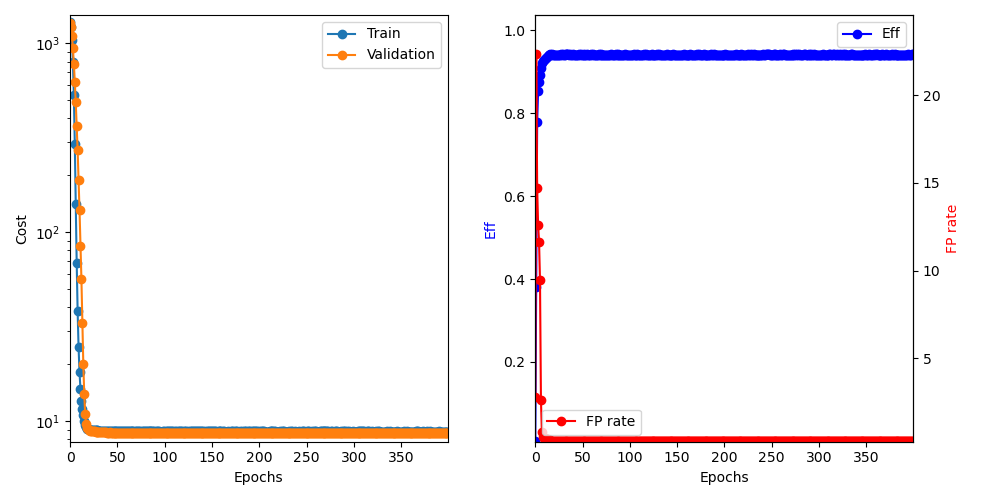

In [11]:
ax, tax, lax, lines = dual_train_plots()
fig = ax.figure
plt.tight_layout()
# This gets built up during the run - do not rerun this cell
results = pd.DataFrame([], columns=Results._fields)

for model:  ACN_3_P_10L_4S_BN(
  (conv1): Conv1d(1, 20, kernel_size=(25,), stride=(1,), padding=(12,))
  (conv2): Conv1d(20, 10, kernel_size=(15,), stride=(1,), padding=(7,))
  (conv3): Conv1d(30, 10, kernel_size=(15,), stride=(1,), padding=(7,))
  (conv4): Conv1d(10, 10, kernel_size=(15,), stride=(1,), padding=(7,))
  (conv5): Conv1d(20, 10, kernel_size=(15,), stride=(1,), padding=(7,))
  (conv6): Conv1d(10, 10, kernel_size=(15,), stride=(1,), padding=(7,))
  (conv7): Conv1d(20, 7, kernel_size=(5,), stride=(1,), padding=(2,))
  (conv8): Conv1d(7, 3, kernel_size=(5,), stride=(1,), padding=(2,))
  (conv9): Conv1d(10, 1, kernel_size=(5,), stride=(1,), padding=(2,))
  (finalFilter): Conv1d(1, 1, kernel_size=(91,), stride=(1,), padding=(45,))
  (ppConv1): Conv1d(2, 20, kernel_size=(25,), stride=(1,), padding=(12,))
  (ppConv2): Conv1d(20, 10, kernel_size=(15,), stride=(1,), padding=(7,))
  (ppConv3): Conv1d(10, 1, kernel_size=(15,), stride=(1,), padding=(7,))
  (ppFC): Linear(in_features=4

/home/michael24peters/pv-finder/notebooks/model/training.py:95: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  file=sys.stderr,


Epoch 1320: train=1292.55, val=1282.21, took 42.027 s
  Validation Found 903 of 108007, added 55634 (eff 0.84%) (2.78 FP/event)
Result epoch:  1320
Average Eff:  0
Average FP Rate:  0


Epoch 1321: train=1217.1, val=1215.03, took 46.424 s
  Validation Found 41100 of 108007, added 447038 (eff 38.05%) (22.4 FP/event)
Result epoch:  1321
Average Eff:  0
Average FP Rate:  0


Epoch 1322: train=1045.6, val=1090.22, took 41.814 s
  Validation Found 84196 of 108007, added 294443 (eff 77.95%) (14.7 FP/event)
Result epoch:  1322
Average Eff:  0
Average FP Rate:  0


Epoch 1323: train=798.53, val=938.648, took 40.693 s
  Validation Found 92113 of 108007, added 251870 (eff 85.28%) (12.6 FP/event)
Result epoch:  1323
Average Eff:  0
Average FP Rate:  0


Epoch 1324: train=532.16, val=779.444, took 41.229 s
  Validation Found 94580 of 108007, added 233055 (eff 87.57%) (11.7 FP/event)
Result epoch:  1324
Average Eff:  0
Average FP Rate:  0


Epoch 1325: train=293.89, val=625.774, took 40.631 s
  Validation Found 96427 of 108007, added 188955 (eff 89.28%) (9.45 FP/event)
Result epoch:  1325
Average Eff:  0
Average FP Rate:  0


Epoch 1326: train=141.451, val=488.898, took 40.912 s
  Validation Found 98222 of 108007, added 51886 (eff 90.94%) (2.59 FP/event)
Result epoch:  1326
Average Eff:  0
Average FP Rate:  0


Epoch 1327: train=68.992, val=363.67, took 40.748 s
  Validation Found 99369 of 108007, added 15962 (eff 92.00%) (0.798 FP/event)
Result epoch:  1327
Average Eff:  0
Average FP Rate:  0


Epoch 1328: train=38.0423, val=270.892, took 40.574 s
  Validation Found 99964 of 108007, added 10331 (eff 92.55%) (0.517 FP/event)
Result epoch:  1328
Average Eff:  0
Average FP Rate:  0


Epoch 1329: train=24.4909, val=188.664, took 41.09 s
  Validation Found 100300 of 108007, added 8817 (eff 92.86%) (0.441 FP/event)
Result epoch:  1329
Average Eff:  0
Average FP Rate:  0


Epoch 1330: train=18.0596, val=130.41, took 40.312 s
  Validation Found 100640 of 108007, added 8474 (eff 93.18%) (0.424 FP/event)
Result epoch:  1330
Average Eff:  0
Average FP Rate:  0


Epoch 1331: train=14.7342, val=84.7108, took 41.027 s
  Validation Found 100892 of 108007, added 8046 (eff 93.41%) (0.402 FP/event)
Result epoch:  1331
Average Eff:  0
Average FP Rate:  0


Epoch 1332: train=12.8209, val=56.441, took 40.426 s
  Validation Found 101035 of 108007, added 7593 (eff 93.54%) (0.38 FP/event)
Result epoch:  1332
Average Eff:  0
Average FP Rate:  0


Epoch 1333: train=11.5855, val=32.9323, took 40.929 s
  Validation Found 101340 of 108007, added 7537 (eff 93.83%) (0.377 FP/event)
Result epoch:  1333
Average Eff:  0
Average FP Rate:  0


Epoch 1334: train=10.6955, val=20.0445, took 40.677 s
  Validation Found 101446 of 108007, added 6954 (eff 93.93%) (0.348 FP/event)
Result epoch:  1334
Average Eff:  0
Average FP Rate:  0


Epoch 1335: train=10.026, val=13.8469, took 40.62 s
  Validation Found 101517 of 108007, added 6414 (eff 93.99%) (0.321 FP/event)
Result epoch:  1335
Average Eff:  0
Average FP Rate:  0


Epoch 1336: train=9.54634, val=10.9051, took 41.02 s
  Validation Found 101711 of 108007, added 6337 (eff 94.17%) (0.317 FP/event)
Result epoch:  1336
Average Eff:  0
Average FP Rate:  0


Epoch 1337: train=9.24083, val=9.66912, took 40.145 s
  Validation Found 101677 of 108007, added 5921 (eff 94.14%) (0.296 FP/event)
Result epoch:  1337
Average Eff:  0
Average FP Rate:  0


Epoch 1338: train=9.08009, val=9.20402, took 41.015 s
  Validation Found 101724 of 108007, added 5909 (eff 94.18%) (0.295 FP/event)
Result epoch:  1338
Average Eff:  0
Average FP Rate:  0


Epoch 1339: train=9.0282, val=9.01676, took 41.409 s
  Validation Found 101569 of 108007, added 5512 (eff 94.04%) (0.276 FP/event)
Result epoch:  1339
Average Eff:  0
Average FP Rate:  0


Epoch 1340: train=9.00897, val=8.95297, took 42.127 s
  Validation Found 101632 of 108007, added 5601 (eff 94.10%) (0.28 FP/event)
Result epoch:  1340
Average Eff:  0
Average FP Rate:  0


Epoch 1341: train=8.99583, val=8.8951, took 41.87 s
  Validation Found 101559 of 108007, added 5361 (eff 94.03%) (0.268 FP/event)
Result epoch:  1341
Average Eff:  0
Average FP Rate:  0


Epoch 1342: train=8.97979, val=8.86358, took 41.569 s
  Validation Found 101598 of 108007, added 5444 (eff 94.07%) (0.272 FP/event)
Result epoch:  1342
Average Eff:  0
Average FP Rate:  0


Epoch 1343: train=8.9653, val=8.85224, took 40.861 s
  Validation Found 101641 of 108007, added 5514 (eff 94.11%) (0.276 FP/event)
Result epoch:  1343
Average Eff:  0
Average FP Rate:  0


Epoch 1344: train=8.95363, val=8.82424, took 41.757 s
  Validation Found 101588 of 108007, added 5407 (eff 94.06%) (0.27 FP/event)
Result epoch:  1344
Average Eff:  0
Average FP Rate:  0


Epoch 1345: train=8.94266, val=8.82477, took 41.263 s
  Validation Found 101502 of 108007, added 5233 (eff 93.98%) (0.262 FP/event)
Result epoch:  1345
Average Eff:  0
Average FP Rate:  0


Epoch 1346: train=8.92783, val=8.79729, took 40.755 s
  Validation Found 101537 of 108007, added 5290 (eff 94.01%) (0.264 FP/event)
Result epoch:  1346
Average Eff:  0
Average FP Rate:  0


Epoch 1347: train=8.91301, val=8.78828, took 41.01 s
  Validation Found 101705 of 108007, added 5570 (eff 94.17%) (0.278 FP/event)
Result epoch:  1347
Average Eff:  0
Average FP Rate:  0


Epoch 1348: train=8.90565, val=8.77794, took 41.142 s
  Validation Found 101651 of 108007, added 5513 (eff 94.12%) (0.276 FP/event)
Result epoch:  1348
Average Eff:  0
Average FP Rate:  0


Epoch 1349: train=8.89851, val=8.75519, took 40.333 s
  Validation Found 101688 of 108007, added 5554 (eff 94.15%) (0.278 FP/event)
Result epoch:  1349
Average Eff:  0
Average FP Rate:  0


Epoch 1350: train=8.88869, val=8.74615, took 41.023 s
  Validation Found 101655 of 108007, added 5471 (eff 94.12%) (0.274 FP/event)
Result epoch:  1350
Average Eff:  0
Average FP Rate:  0


Epoch 1351: train=8.87717, val=8.74169, took 39.579 s
  Validation Found 101602 of 108007, added 5376 (eff 94.07%) (0.269 FP/event)
Result epoch:  1351
Average Eff:  0
Average FP Rate:  0


Epoch 1352: train=8.87251, val=8.72908, took 41.144 s
  Validation Found 101688 of 108007, added 5542 (eff 94.15%) (0.277 FP/event)
Result epoch:  1352
Average Eff:  0
Average FP Rate:  0


Epoch 1353: train=8.86806, val=8.72456, took 41.087 s
  Validation Found 101737 of 108007, added 5627 (eff 94.19%) (0.281 FP/event)
Result epoch:  1353
Average Eff:  0
Average FP Rate:  0


Epoch 1354: train=8.86197, val=8.72276, took 40.611 s
  Validation Found 101709 of 108007, added 5579 (eff 94.17%) (0.279 FP/event)
Result epoch:  1354
Average Eff:  0
Average FP Rate:  0


Epoch 1355: train=8.85397, val=8.70635, took 41.903 s
  Validation Found 101713 of 108007, added 5533 (eff 94.17%) (0.277 FP/event)
Result epoch:  1355
Average Eff:  0
Average FP Rate:  0


Epoch 1356: train=8.84402, val=8.69985, took 41.04 s
  Validation Found 101633 of 108007, added 5391 (eff 94.10%) (0.27 FP/event)
Result epoch:  1356
Average Eff:  0
Average FP Rate:  0


Epoch 1357: train=8.83996, val=8.68888, took 41.72 s
  Validation Found 101696 of 108007, added 5522 (eff 94.16%) (0.276 FP/event)
Result epoch:  1357
Average Eff:  0
Average FP Rate:  0


Epoch 1358: train=8.83936, val=8.6892, took 41.252 s
  Validation Found 101654 of 108007, added 5420 (eff 94.12%) (0.271 FP/event)
Result epoch:  1358
Average Eff:  0
Average FP Rate:  0


Epoch 1359: train=8.83343, val=8.67766, took 41.564 s
  Validation Found 101625 of 108007, added 5376 (eff 94.09%) (0.269 FP/event)
Result epoch:  1359
Average Eff:  0
Average FP Rate:  0


Epoch 1360: train=8.827, val=8.67457, took 41.525 s
  Validation Found 101717 of 108007, added 5565 (eff 94.18%) (0.278 FP/event)
Result epoch:  1360
Average Eff:  0
Average FP Rate:  0


Epoch 1361: train=8.82345, val=8.68025, took 41.237 s
  Validation Found 101685 of 108007, added 5497 (eff 94.15%) (0.275 FP/event)
Result epoch:  1361
Average Eff:  0
Average FP Rate:  0


Epoch 1362: train=8.82681, val=8.68436, took 41.832 s
  Validation Found 101633 of 108007, added 5393 (eff 94.10%) (0.27 FP/event)
Result epoch:  1362
Average Eff:  0
Average FP Rate:  0


Epoch 1363: train=8.81959, val=8.67037, took 41.057 s
  Validation Found 101610 of 108007, added 5350 (eff 94.08%) (0.267 FP/event)
Result epoch:  1363
Average Eff:  0
Average FP Rate:  0


Epoch 1364: train=8.81772, val=8.67083, took 41.714 s
  Validation Found 101628 of 108007, added 5389 (eff 94.09%) (0.269 FP/event)
Result epoch:  1364
Average Eff:  0
Average FP Rate:  0


Epoch 1365: train=8.81927, val=8.67199, took 41.523 s
  Validation Found 101649 of 108007, added 5415 (eff 94.11%) (0.271 FP/event)
Result epoch:  1365
Average Eff:  0
Average FP Rate:  0


Epoch 1366: train=8.81137, val=8.66631, took 41.907 s
  Validation Found 101724 of 108007, added 5596 (eff 94.18%) (0.28 FP/event)
Result epoch:  1366
Average Eff:  0
Average FP Rate:  0


Epoch 1367: train=8.80932, val=8.65647, took 40.975 s
  Validation Found 101645 of 108007, added 5404 (eff 94.11%) (0.27 FP/event)
Result epoch:  1367
Average Eff:  0
Average FP Rate:  0


Epoch 1368: train=8.8071, val=8.64868, took 40.684 s
  Validation Found 101737 of 108007, added 5568 (eff 94.19%) (0.278 FP/event)
Result epoch:  1368
Average Eff:  0
Average FP Rate:  0


Epoch 1369: train=8.80677, val=8.65006, took 41.301 s
  Validation Found 101598 of 108007, added 5355 (eff 94.07%) (0.268 FP/event)
Result epoch:  1369
Average Eff:  0
Average FP Rate:  0


Epoch 1370: train=8.81192, val=8.65223, took 41.097 s
  Validation Found 101644 of 108007, added 5438 (eff 94.11%) (0.272 FP/event)
Result epoch:  1370
Average Eff:  0
Average FP Rate:  0


Epoch 1371: train=8.80338, val=8.64903, took 41.997 s
  Validation Found 101701 of 108007, added 5540 (eff 94.16%) (0.277 FP/event)
Result epoch:  1371
Average Eff:  0
Average FP Rate:  0


Epoch 1372: train=8.80735, val=8.64179, took 41.322 s
  Validation Found 101655 of 108007, added 5484 (eff 94.12%) (0.274 FP/event)
Result epoch:  1372
Average Eff:  0
Average FP Rate:  0


Epoch 1373: train=8.80457, val=8.64803, took 41.347 s
  Validation Found 101639 of 108007, added 5421 (eff 94.10%) (0.271 FP/event)
Result epoch:  1373
Average Eff:  0
Average FP Rate:  0


Epoch 1374: train=8.80048, val=8.6411, took 41.751 s
  Validation Found 101588 of 108007, added 5347 (eff 94.06%) (0.267 FP/event)
Result epoch:  1374
Average Eff:  0
Average FP Rate:  0


Epoch 1375: train=8.80114, val=8.64845, took 41.006 s
  Validation Found 101703 of 108007, added 5540 (eff 94.16%) (0.277 FP/event)
Result epoch:  1375
Average Eff:  0
Average FP Rate:  0


Epoch 1376: train=8.79938, val=8.65544, took 41.797 s
  Validation Found 101533 of 108007, added 5270 (eff 94.01%) (0.263 FP/event)
Result epoch:  1376
Average Eff:  0
Average FP Rate:  0


Epoch 1377: train=8.80065, val=8.63989, took 41.049 s
  Validation Found 101675 of 108007, added 5492 (eff 94.14%) (0.275 FP/event)
Result epoch:  1377
Average Eff:  0
Average FP Rate:  0


Epoch 1378: train=8.79489, val=8.64545, took 41.746 s
  Validation Found 101617 of 108007, added 5364 (eff 94.08%) (0.268 FP/event)
Result epoch:  1378
Average Eff:  0
Average FP Rate:  0


Epoch 1379: train=8.7958, val=8.63784, took 41.291 s
  Validation Found 101692 of 108007, added 5520 (eff 94.15%) (0.276 FP/event)
Result epoch:  1379
Average Eff:  0
Average FP Rate:  0


Epoch 1380: train=8.7939, val=8.64302, took 41.445 s
  Validation Found 101676 of 108007, added 5466 (eff 94.14%) (0.273 FP/event)
Result epoch:  1380
Average Eff:  0
Average FP Rate:  0


Epoch 1381: train=8.79639, val=8.63359, took 41.55 s
  Validation Found 101704 of 108007, added 5542 (eff 94.16%) (0.277 FP/event)
Result epoch:  1381
Average Eff:  0
Average FP Rate:  0


Epoch 1382: train=8.79021, val=8.63918, took 41.059 s
  Validation Found 101566 of 108007, added 5302 (eff 94.04%) (0.265 FP/event)
Result epoch:  1382
Average Eff:  0
Average FP Rate:  0


Epoch 1383: train=8.79114, val=8.63662, took 41.629 s
  Validation Found 101620 of 108007, added 5362 (eff 94.09%) (0.268 FP/event)
Result epoch:  1383
Average Eff:  0
Average FP Rate:  0


Epoch 1384: train=8.79212, val=8.64177, took 40.844 s
  Validation Found 101685 of 108007, added 5483 (eff 94.15%) (0.274 FP/event)
Result epoch:  1384
Average Eff:  0
Average FP Rate:  0


Epoch 1385: train=8.79456, val=8.63837, took 41.563 s
  Validation Found 101646 of 108007, added 5445 (eff 94.11%) (0.272 FP/event)
Result epoch:  1385
Average Eff:  0
Average FP Rate:  0


Epoch 1386: train=8.79725, val=8.63985, took 41.051 s
  Validation Found 101584 of 108007, added 5316 (eff 94.05%) (0.266 FP/event)
Result epoch:  1386
Average Eff:  0
Average FP Rate:  0


Epoch 1387: train=8.80014, val=8.63516, took 41.072 s
  Validation Found 101692 of 108007, added 5498 (eff 94.15%) (0.275 FP/event)
Result epoch:  1387
Average Eff:  0
Average FP Rate:  0


Epoch 1388: train=8.78885, val=8.63779, took 40.784 s
  Validation Found 101627 of 108007, added 5412 (eff 94.09%) (0.271 FP/event)
Result epoch:  1388
Average Eff:  0
Average FP Rate:  0


Epoch 1389: train=8.7917, val=8.63829, took 40.874 s
  Validation Found 101688 of 108007, added 5473 (eff 94.15%) (0.274 FP/event)
Result epoch:  1389
Average Eff:  0
Average FP Rate:  0


Epoch 1390: train=8.79058, val=8.64579, took 41.276 s
  Validation Found 101604 of 108007, added 5357 (eff 94.07%) (0.268 FP/event)
Result epoch:  1390
Average Eff:  0
Average FP Rate:  0


Epoch 1391: train=8.79677, val=8.63993, took 40.508 s
  Validation Found 101677 of 108007, added 5483 (eff 94.14%) (0.274 FP/event)
Result epoch:  1391
Average Eff:  0
Average FP Rate:  0


Epoch 1392: train=8.79277, val=8.63039, took 41.228 s
  Validation Found 101647 of 108007, added 5414 (eff 94.11%) (0.271 FP/event)
Result epoch:  1392
Average Eff:  0
Average FP Rate:  0


Epoch 1393: train=8.7924, val=8.6416, took 40.689 s
  Validation Found 101652 of 108007, added 5412 (eff 94.12%) (0.271 FP/event)
Result epoch:  1393
Average Eff:  0
Average FP Rate:  0


Epoch 1394: train=8.79105, val=8.63495, took 41.014 s
  Validation Found 101607 of 108007, added 5340 (eff 94.07%) (0.267 FP/event)
Result epoch:  1394
Average Eff:  0
Average FP Rate:  0


Epoch 1395: train=8.78836, val=8.63447, took 40.995 s
  Validation Found 101645 of 108007, added 5423 (eff 94.11%) (0.271 FP/event)
Result epoch:  1395
Average Eff:  0
Average FP Rate:  0


Epoch 1396: train=8.79269, val=8.64152, took 40.679 s
  Validation Found 101608 of 108007, added 5347 (eff 94.08%) (0.267 FP/event)
Result epoch:  1396
Average Eff:  0
Average FP Rate:  0


Epoch 1397: train=8.79003, val=8.62899, took 41.986 s
  Validation Found 101673 of 108007, added 5471 (eff 94.14%) (0.274 FP/event)
Result epoch:  1397
Average Eff:  0
Average FP Rate:  0


Epoch 1398: train=8.79292, val=8.63582, took 42.127 s
  Validation Found 101662 of 108007, added 5436 (eff 94.13%) (0.272 FP/event)
Result epoch:  1398
Average Eff:  0
Average FP Rate:  0


Epoch 1399: train=8.79025, val=8.63562, took 41.386 s
  Validation Found 101570 of 108007, added 5319 (eff 94.04%) (0.266 FP/event)
Result epoch:  1399
Average Eff:  0
Average FP Rate:  0


Epoch 1400: train=8.79293, val=8.62715, took 41.229 s
  Validation Found 101695 of 108007, added 5495 (eff 94.16%) (0.275 FP/event)
Result epoch:  1400
Average Eff:  0
Average FP Rate:  0


Epoch 1401: train=8.78936, val=8.63354, took 41.297 s
  Validation Found 101680 of 108007, added 5474 (eff 94.14%) (0.274 FP/event)
Result epoch:  1401
Average Eff:  0
Average FP Rate:  0


Epoch 1402: train=8.79321, val=8.64209, took 40.564 s
  Validation Found 101675 of 108007, added 5471 (eff 94.14%) (0.274 FP/event)
Result epoch:  1402
Average Eff:  0
Average FP Rate:  0


Epoch 1403: train=8.79175, val=8.63395, took 41.188 s
  Validation Found 101661 of 108007, added 5453 (eff 94.12%) (0.273 FP/event)
Result epoch:  1403
Average Eff:  0
Average FP Rate:  0


Epoch 1404: train=8.79484, val=8.62932, took 40.669 s
  Validation Found 101683 of 108007, added 5503 (eff 94.14%) (0.275 FP/event)
Result epoch:  1404
Average Eff:  0
Average FP Rate:  0


Epoch 1405: train=8.79105, val=8.63271, took 40.979 s
  Validation Found 101715 of 108007, added 5558 (eff 94.17%) (0.278 FP/event)
Result epoch:  1405
Average Eff:  0
Average FP Rate:  0


Epoch 1406: train=8.79417, val=8.62892, took 41.016 s
  Validation Found 101668 of 108007, added 5474 (eff 94.13%) (0.274 FP/event)
Result epoch:  1406
Average Eff:  0
Average FP Rate:  0


Epoch 1407: train=8.79464, val=8.64066, took 40.699 s
  Validation Found 101698 of 108007, added 5510 (eff 94.16%) (0.275 FP/event)
Result epoch:  1407
Average Eff:  0
Average FP Rate:  0


Epoch 1408: train=8.79004, val=8.63037, took 41.285 s
  Validation Found 101666 of 108007, added 5432 (eff 94.13%) (0.272 FP/event)
Result epoch:  1408
Average Eff:  0
Average FP Rate:  0


Epoch 1409: train=8.7956, val=8.63575, took 42.001 s
  Validation Found 101645 of 108007, added 5419 (eff 94.11%) (0.271 FP/event)
Result epoch:  1409
Average Eff:  0
Average FP Rate:  0


Epoch 1410: train=8.78828, val=8.62745, took 42.041 s
  Validation Found 101623 of 108007, added 5377 (eff 94.09%) (0.269 FP/event)
Result epoch:  1410
Average Eff:  0
Average FP Rate:  0


Epoch 1411: train=8.79495, val=8.63837, took 42.124 s
  Validation Found 101660 of 108007, added 5454 (eff 94.12%) (0.273 FP/event)
Result epoch:  1411
Average Eff:  0
Average FP Rate:  0


Epoch 1412: train=8.79328, val=8.6348, took 41.783 s
  Validation Found 101621 of 108007, added 5402 (eff 94.09%) (0.27 FP/event)
Result epoch:  1412
Average Eff:  0
Average FP Rate:  0


Epoch 1413: train=8.78935, val=8.63098, took 41.896 s
  Validation Found 101666 of 108007, added 5478 (eff 94.13%) (0.274 FP/event)
Result epoch:  1413
Average Eff:  0
Average FP Rate:  0


Epoch 1414: train=8.79552, val=8.62976, took 41.226 s
  Validation Found 101677 of 108007, added 5480 (eff 94.14%) (0.274 FP/event)
Result epoch:  1414
Average Eff:  0
Average FP Rate:  0


Epoch 1415: train=8.78876, val=8.62363, took 41.364 s
  Validation Found 101725 of 108007, added 5568 (eff 94.18%) (0.278 FP/event)
Result epoch:  1415
Average Eff:  0
Average FP Rate:  0


Epoch 1416: train=8.78853, val=8.63396, took 40.778 s
  Validation Found 101624 of 108007, added 5387 (eff 94.09%) (0.269 FP/event)
Result epoch:  1416
Average Eff:  0
Average FP Rate:  0


Epoch 1417: train=8.78731, val=8.63696, took 41.059 s
  Validation Found 101632 of 108007, added 5384 (eff 94.10%) (0.269 FP/event)
Result epoch:  1417
Average Eff:  0
Average FP Rate:  0


Epoch 1418: train=8.7924, val=8.63877, took 40.907 s
  Validation Found 101633 of 108007, added 5411 (eff 94.10%) (0.271 FP/event)
Result epoch:  1418
Average Eff:  0
Average FP Rate:  0


Epoch 1419: train=8.79234, val=8.64233, took 40.724 s
  Validation Found 101645 of 108007, added 5433 (eff 94.11%) (0.272 FP/event)
Result epoch:  1419
Average Eff:  0
Average FP Rate:  0


Epoch 1420: train=8.78876, val=8.64504, took 41.278 s
  Validation Found 101662 of 108007, added 5471 (eff 94.13%) (0.274 FP/event)
Result epoch:  1420
Average Eff:  0
Average FP Rate:  0


Epoch 1421: train=8.79142, val=8.63281, took 40.541 s
  Validation Found 101678 of 108007, added 5477 (eff 94.14%) (0.274 FP/event)
Result epoch:  1421
Average Eff:  0
Average FP Rate:  0


Epoch 1422: train=8.78919, val=8.63581, took 41.193 s
  Validation Found 101587 of 108007, added 5344 (eff 94.06%) (0.267 FP/event)
Result epoch:  1422
Average Eff:  0
Average FP Rate:  0


Epoch 1423: train=8.78912, val=8.63254, took 40.717 s
  Validation Found 101656 of 108007, added 5453 (eff 94.12%) (0.273 FP/event)
Result epoch:  1423
Average Eff:  0
Average FP Rate:  0


Epoch 1424: train=8.79242, val=8.63818, took 40.972 s
  Validation Found 101715 of 108007, added 5541 (eff 94.17%) (0.277 FP/event)
Result epoch:  1424
Average Eff:  0
Average FP Rate:  0


Epoch 1425: train=8.79046, val=8.63362, took 41.948 s
  Validation Found 101609 of 108007, added 5355 (eff 94.08%) (0.268 FP/event)
Result epoch:  1425
Average Eff:  0
Average FP Rate:  0


Epoch 1426: train=8.79129, val=8.63219, took 41.556 s
  Validation Found 101669 of 108007, added 5444 (eff 94.13%) (0.272 FP/event)
Result epoch:  1426
Average Eff:  0
Average FP Rate:  0


Epoch 1427: train=8.79367, val=8.63066, took 42.128 s
  Validation Found 101634 of 108007, added 5404 (eff 94.10%) (0.27 FP/event)
Result epoch:  1427
Average Eff:  0
Average FP Rate:  0


Epoch 1428: train=8.79101, val=8.64541, took 41.422 s
  Validation Found 101724 of 108007, added 5570 (eff 94.18%) (0.278 FP/event)
Result epoch:  1428
Average Eff:  0
Average FP Rate:  0


Epoch 1429: train=8.7937, val=8.63156, took 42.021 s
  Validation Found 101597 of 108007, added 5359 (eff 94.07%) (0.268 FP/event)
Result epoch:  1429
Average Eff:  0
Average FP Rate:  0


Epoch 1430: train=8.78787, val=8.63666, took 41.955 s
  Validation Found 101639 of 108007, added 5408 (eff 94.10%) (0.27 FP/event)
Result epoch:  1430
Average Eff:  0
Average FP Rate:  0


Epoch 1431: train=8.78954, val=8.63302, took 41.84 s
  Validation Found 101542 of 108007, added 5278 (eff 94.01%) (0.264 FP/event)
Result epoch:  1431
Average Eff:  0
Average FP Rate:  0


Epoch 1432: train=8.79005, val=8.63754, took 41.232 s
  Validation Found 101599 of 108007, added 5353 (eff 94.07%) (0.268 FP/event)
Result epoch:  1432
Average Eff:  0
Average FP Rate:  0


Epoch 1433: train=8.78487, val=8.63428, took 41.194 s
  Validation Found 101657 of 108007, added 5444 (eff 94.12%) (0.272 FP/event)
Result epoch:  1433
Average Eff:  0
Average FP Rate:  0


Epoch 1434: train=8.79273, val=8.62926, took 40.97 s
  Validation Found 101618 of 108007, added 5387 (eff 94.08%) (0.269 FP/event)
Result epoch:  1434
Average Eff:  0
Average FP Rate:  0


Epoch 1435: train=8.79166, val=8.63121, took 40.392 s
  Validation Found 101689 of 108007, added 5504 (eff 94.15%) (0.275 FP/event)
Result epoch:  1435
Average Eff:  0
Average FP Rate:  0


Epoch 1436: train=8.79468, val=8.62292, took 41.131 s
  Validation Found 101648 of 108007, added 5437 (eff 94.11%) (0.272 FP/event)
Result epoch:  1436
Average Eff:  0
Average FP Rate:  0


Epoch 1437: train=8.79139, val=8.62587, took 40.384 s
  Validation Found 101731 of 108007, added 5605 (eff 94.19%) (0.28 FP/event)
Result epoch:  1437
Average Eff:  0
Average FP Rate:  0


Epoch 1438: train=8.79279, val=8.63915, took 40.929 s
  Validation Found 101569 of 108007, added 5338 (eff 94.04%) (0.267 FP/event)
Result epoch:  1438
Average Eff:  0
Average FP Rate:  0


Epoch 1439: train=8.78475, val=8.63472, took 40.622 s
  Validation Found 101668 of 108007, added 5443 (eff 94.13%) (0.272 FP/event)
Result epoch:  1439
Average Eff:  0
Average FP Rate:  0


Epoch 1440: train=8.79267, val=8.64312, took 40.833 s
  Validation Found 101608 of 108007, added 5356 (eff 94.08%) (0.268 FP/event)
Result epoch:  1440
Average Eff:  0
Average FP Rate:  0


Epoch 1441: train=8.78703, val=8.63717, took 41.288 s
  Validation Found 101595 of 108007, added 5357 (eff 94.06%) (0.268 FP/event)
Result epoch:  1441
Average Eff:  0
Average FP Rate:  0


Epoch 1442: train=8.79296, val=8.63303, took 40.503 s
  Validation Found 101609 of 108007, added 5361 (eff 94.08%) (0.268 FP/event)
Result epoch:  1442
Average Eff:  0
Average FP Rate:  0


Epoch 1443: train=8.7906, val=8.62929, took 41.285 s
  Validation Found 101698 of 108007, added 5511 (eff 94.16%) (0.276 FP/event)
Result epoch:  1443
Average Eff:  0
Average FP Rate:  0


Epoch 1444: train=8.78857, val=8.63884, took 40.533 s
  Validation Found 101631 of 108007, added 5391 (eff 94.10%) (0.27 FP/event)
Result epoch:  1444
Average Eff:  0
Average FP Rate:  0


Epoch 1445: train=8.79156, val=8.63672, took 41.289 s
  Validation Found 101561 of 108007, added 5321 (eff 94.03%) (0.266 FP/event)
Result epoch:  1445
Average Eff:  0
Average FP Rate:  0


Epoch 1446: train=8.78778, val=8.63635, took 40.936 s
  Validation Found 101609 of 108007, added 5397 (eff 94.08%) (0.27 FP/event)
Result epoch:  1446
Average Eff:  0
Average FP Rate:  0


Epoch 1447: train=8.79168, val=8.62867, took 41.048 s
  Validation Found 101613 of 108007, added 5369 (eff 94.08%) (0.268 FP/event)
Result epoch:  1447
Average Eff:  0
Average FP Rate:  0


Epoch 1448: train=8.78939, val=8.63415, took 41.423 s
  Validation Found 101601 of 108007, added 5350 (eff 94.07%) (0.267 FP/event)
Result epoch:  1448
Average Eff:  0
Average FP Rate:  0


Epoch 1449: train=8.79186, val=8.62184, took 40.649 s
  Validation Found 101717 of 108007, added 5527 (eff 94.18%) (0.276 FP/event)
Result epoch:  1449
Average Eff:  0
Average FP Rate:  0


Epoch 1450: train=8.79025, val=8.63512, took 41.378 s
  Validation Found 101604 of 108007, added 5335 (eff 94.07%) (0.267 FP/event)
Result epoch:  1450
Average Eff:  0
Average FP Rate:  0


Epoch 1451: train=8.79188, val=8.63145, took 40.811 s
  Validation Found 101689 of 108007, added 5512 (eff 94.15%) (0.276 FP/event)
Result epoch:  1451
Average Eff:  0
Average FP Rate:  0


Epoch 1452: train=8.7912, val=8.63225, took 41.697 s
  Validation Found 101619 of 108007, added 5390 (eff 94.09%) (0.269 FP/event)
Result epoch:  1452
Average Eff:  0
Average FP Rate:  0


Epoch 1453: train=8.79049, val=8.6273, took 41.009 s
  Validation Found 101558 of 108007, added 5309 (eff 94.03%) (0.265 FP/event)
Result epoch:  1453
Average Eff:  0
Average FP Rate:  0


Epoch 1454: train=8.79267, val=8.63597, took 41.064 s
  Validation Found 101597 of 108007, added 5328 (eff 94.07%) (0.266 FP/event)
Result epoch:  1454
Average Eff:  0
Average FP Rate:  0


Epoch 1455: train=8.79109, val=8.63844, took 41.402 s
  Validation Found 101605 of 108007, added 5358 (eff 94.07%) (0.268 FP/event)
Result epoch:  1455
Average Eff:  0
Average FP Rate:  0


Epoch 1456: train=8.79259, val=8.63787, took 40.629 s
  Validation Found 101594 of 108007, added 5329 (eff 94.06%) (0.266 FP/event)
Result epoch:  1456
Average Eff:  0
Average FP Rate:  0


Epoch 1457: train=8.79032, val=8.63507, took 41.393 s
  Validation Found 101579 of 108007, added 5332 (eff 94.05%) (0.267 FP/event)
Result epoch:  1457
Average Eff:  0
Average FP Rate:  0


Epoch 1458: train=8.7931, val=8.63, took 41.67 s
  Validation Found 101637 of 108007, added 5385 (eff 94.10%) (0.269 FP/event)
Result epoch:  1458
Average Eff:  0
Average FP Rate:  0


Epoch 1459: train=8.79263, val=8.62597, took 41.224 s
  Validation Found 101699 of 108007, added 5496 (eff 94.16%) (0.275 FP/event)
Result epoch:  1459
Average Eff:  0
Average FP Rate:  0


Epoch 1460: train=8.78698, val=8.64016, took 41.43 s
  Validation Found 101600 of 108007, added 5355 (eff 94.07%) (0.268 FP/event)
Result epoch:  1460
Average Eff:  0
Average FP Rate:  0


Epoch 1461: train=8.78972, val=8.63163, took 41.43 s
  Validation Found 101615 of 108007, added 5351 (eff 94.08%) (0.268 FP/event)
Result epoch:  1461
Average Eff:  0
Average FP Rate:  0


Epoch 1462: train=8.7868, val=8.63841, took 42.354 s
  Validation Found 101605 of 108007, added 5351 (eff 94.07%) (0.268 FP/event)
Result epoch:  1462
Average Eff:  0
Average FP Rate:  0


Epoch 1463: train=8.78949, val=8.62769, took 42.227 s
  Validation Found 101644 of 108007, added 5413 (eff 94.11%) (0.271 FP/event)
Result epoch:  1463
Average Eff:  0
Average FP Rate:  0


Epoch 1464: train=8.78887, val=8.62147, took 41.587 s
  Validation Found 101627 of 108007, added 5389 (eff 94.09%) (0.269 FP/event)
Result epoch:  1464
Average Eff:  0
Average FP Rate:  0


Epoch 1465: train=8.79228, val=8.64233, took 40.798 s
  Validation Found 101626 of 108007, added 5410 (eff 94.09%) (0.27 FP/event)
Result epoch:  1465
Average Eff:  0
Average FP Rate:  0


Epoch 1466: train=8.79233, val=8.63575, took 41.021 s
  Validation Found 101798 of 108007, added 5774 (eff 94.25%) (0.289 FP/event)
Result epoch:  1466
Average Eff:  0
Average FP Rate:  0


Epoch 1467: train=8.79424, val=8.64037, took 40.897 s
  Validation Found 101624 of 108007, added 5402 (eff 94.09%) (0.27 FP/event)
Result epoch:  1467
Average Eff:  0
Average FP Rate:  0


Epoch 1468: train=8.79563, val=8.63432, took 40.637 s
  Validation Found 101667 of 108007, added 5466 (eff 94.13%) (0.273 FP/event)
Result epoch:  1468
Average Eff:  0
Average FP Rate:  0


Epoch 1469: train=8.79217, val=8.63763, took 41.185 s
  Validation Found 101687 of 108007, added 5490 (eff 94.15%) (0.274 FP/event)
Result epoch:  1469
Average Eff:  0
Average FP Rate:  0


Epoch 1470: train=8.79414, val=8.62718, took 40.448 s
  Validation Found 101625 of 108007, added 5371 (eff 94.09%) (0.269 FP/event)
Result epoch:  1470
Average Eff:  0
Average FP Rate:  0


Epoch 1471: train=8.79023, val=8.63682, took 41.099 s
  Validation Found 101583 of 108007, added 5328 (eff 94.05%) (0.266 FP/event)
Result epoch:  1471
Average Eff:  0
Average FP Rate:  0


Epoch 1472: train=8.79057, val=8.63384, took 40.653 s
  Validation Found 101671 of 108007, added 5457 (eff 94.13%) (0.273 FP/event)
Result epoch:  1472
Average Eff:  0
Average FP Rate:  0


Epoch 1473: train=8.79135, val=8.63367, took 40.938 s
  Validation Found 101683 of 108007, added 5475 (eff 94.14%) (0.274 FP/event)
Result epoch:  1473
Average Eff:  0
Average FP Rate:  0


Epoch 1474: train=8.79067, val=8.63111, took 41.005 s
  Validation Found 101602 of 108007, added 5371 (eff 94.07%) (0.269 FP/event)
Result epoch:  1474
Average Eff:  0
Average FP Rate:  0


Epoch 1475: train=8.78742, val=8.62606, took 40.767 s
  Validation Found 101642 of 108007, added 5419 (eff 94.11%) (0.271 FP/event)
Result epoch:  1475
Average Eff:  0
Average FP Rate:  0


Epoch 1476: train=8.78423, val=8.64265, took 41.369 s
  Validation Found 101624 of 108007, added 5382 (eff 94.09%) (0.269 FP/event)
Result epoch:  1476
Average Eff:  0
Average FP Rate:  0


Epoch 1477: train=8.79013, val=8.63319, took 40.63 s
  Validation Found 101717 of 108007, added 5561 (eff 94.18%) (0.278 FP/event)
Result epoch:  1477
Average Eff:  0
Average FP Rate:  0


Epoch 1478: train=8.78987, val=8.64106, took 41.238 s
  Validation Found 101607 of 108007, added 5356 (eff 94.07%) (0.268 FP/event)
Result epoch:  1478
Average Eff:  0
Average FP Rate:  0


Epoch 1479: train=8.79385, val=8.64528, took 41.315 s
  Validation Found 101521 of 108007, added 5245 (eff 93.99%) (0.262 FP/event)
Result epoch:  1479
Average Eff:  0
Average FP Rate:  0


Epoch 1480: train=8.78967, val=8.63633, took 41.741 s
  Validation Found 101562 of 108007, added 5297 (eff 94.03%) (0.265 FP/event)
Result epoch:  1480
Average Eff:  0
Average FP Rate:  0


Epoch 1481: train=8.78861, val=8.63491, took 42.188 s
  Validation Found 101585 of 108007, added 5327 (eff 94.05%) (0.266 FP/event)
Result epoch:  1481
Average Eff:  0
Average FP Rate:  0


Epoch 1482: train=8.79025, val=8.6339, took 41.095 s
  Validation Found 101639 of 108007, added 5409 (eff 94.10%) (0.27 FP/event)
Result epoch:  1482
Average Eff:  0
Average FP Rate:  0


Epoch 1483: train=8.79437, val=8.63068, took 41.191 s
  Validation Found 101657 of 108007, added 5415 (eff 94.12%) (0.271 FP/event)
Result epoch:  1483
Average Eff:  0
Average FP Rate:  0


Epoch 1484: train=8.78842, val=8.63506, took 40.654 s
  Validation Found 101717 of 108007, added 5543 (eff 94.18%) (0.277 FP/event)
Result epoch:  1484
Average Eff:  0
Average FP Rate:  0


Epoch 1485: train=8.78822, val=8.635, took 40.988 s
  Validation Found 101615 of 108007, added 5369 (eff 94.08%) (0.268 FP/event)
Result epoch:  1485
Average Eff:  0
Average FP Rate:  0


Epoch 1486: train=8.78786, val=8.63014, took 40.736 s
  Validation Found 101678 of 108007, added 5462 (eff 94.14%) (0.273 FP/event)
Result epoch:  1486
Average Eff:  0
Average FP Rate:  0


Epoch 1487: train=8.79279, val=8.63145, took 40.768 s
  Validation Found 101687 of 108007, added 5496 (eff 94.15%) (0.275 FP/event)
Result epoch:  1487
Average Eff:  0
Average FP Rate:  0


Epoch 1488: train=8.78731, val=8.6249, took 41.165 s
  Validation Found 101662 of 108007, added 5424 (eff 94.13%) (0.271 FP/event)
Result epoch:  1488
Average Eff:  0
Average FP Rate:  0


Epoch 1489: train=8.78749, val=8.63542, took 40.748 s
  Validation Found 101603 of 108007, added 5354 (eff 94.07%) (0.268 FP/event)
Result epoch:  1489
Average Eff:  0
Average FP Rate:  0


Epoch 1490: train=8.78964, val=8.63895, took 42.183 s
  Validation Found 101633 of 108007, added 5373 (eff 94.10%) (0.269 FP/event)
Result epoch:  1490
Average Eff:  0
Average FP Rate:  0


Epoch 1491: train=8.78989, val=8.64084, took 41.69 s
  Validation Found 101722 of 108007, added 5588 (eff 94.18%) (0.279 FP/event)
Result epoch:  1491
Average Eff:  0
Average FP Rate:  0


Epoch 1492: train=8.79014, val=8.62365, took 41.786 s
  Validation Found 101665 of 108007, added 5444 (eff 94.13%) (0.272 FP/event)
Result epoch:  1492
Average Eff:  0
Average FP Rate:  0


Epoch 1493: train=8.78756, val=8.63491, took 41.075 s
  Validation Found 101716 of 108007, added 5565 (eff 94.18%) (0.278 FP/event)
Result epoch:  1493
Average Eff:  0
Average FP Rate:  0


Epoch 1494: train=8.79149, val=8.63551, took 40.533 s
  Validation Found 101658 of 108007, added 5433 (eff 94.12%) (0.272 FP/event)
Result epoch:  1494
Average Eff:  0
Average FP Rate:  0


Epoch 1495: train=8.79288, val=8.63626, took 41.127 s
  Validation Found 101543 of 108007, added 5244 (eff 94.02%) (0.262 FP/event)
Result epoch:  1495
Average Eff:  0
Average FP Rate:  0


Epoch 1496: train=8.79289, val=8.63122, took 40.69 s
  Validation Found 101586 of 108007, added 5309 (eff 94.06%) (0.265 FP/event)
Result epoch:  1496
Average Eff:  0
Average FP Rate:  0


Epoch 1497: train=8.78837, val=8.6314, took 40.86 s
  Validation Found 101613 of 108007, added 5358 (eff 94.08%) (0.268 FP/event)
Result epoch:  1497
Average Eff:  0
Average FP Rate:  0


Epoch 1498: train=8.78599, val=8.63806, took 41.924 s
  Validation Found 101691 of 108007, added 5506 (eff 94.15%) (0.275 FP/event)
Result epoch:  1498
Average Eff:  0
Average FP Rate:  0


Epoch 1499: train=8.78789, val=8.63955, took 41.142 s
  Validation Found 101626 of 108007, added 5391 (eff 94.09%) (0.27 FP/event)
Result epoch:  1499
Average Eff:  0
Average FP Rate:  0


Epoch 1500: train=8.79119, val=8.62964, took 41.862 s
  Validation Found 101638 of 108007, added 5412 (eff 94.10%) (0.271 FP/event)
Result epoch:  1500
Average Eff:  0
Average FP Rate:  0


Epoch 1501: train=8.78687, val=8.63536, took 41.219 s
  Validation Found 101657 of 108007, added 5427 (eff 94.12%) (0.271 FP/event)
Result epoch:  1501
Average Eff:  0
Average FP Rate:  0


Epoch 1502: train=8.79029, val=8.63197, took 41.51 s
  Validation Found 101646 of 108007, added 5413 (eff 94.11%) (0.271 FP/event)
Result epoch:  1502
Average Eff:  0
Average FP Rate:  0


Epoch 1503: train=8.78602, val=8.6293, took 41.273 s
  Validation Found 101676 of 108007, added 5493 (eff 94.14%) (0.275 FP/event)
Result epoch:  1503
Average Eff:  0
Average FP Rate:  0


Epoch 1504: train=8.79009, val=8.63456, took 41.349 s
  Validation Found 101653 of 108007, added 5420 (eff 94.12%) (0.271 FP/event)
Result epoch:  1504
Average Eff:  0
Average FP Rate:  0


Epoch 1505: train=8.7899, val=8.64703, took 41.598 s
  Validation Found 101526 of 108007, added 5272 (eff 94.00%) (0.264 FP/event)
Result epoch:  1505
Average Eff:  0
Average FP Rate:  0


Epoch 1506: train=8.79038, val=8.63821, took 40.381 s
  Validation Found 101694 of 108007, added 5491 (eff 94.16%) (0.275 FP/event)
Result epoch:  1506
Average Eff:  0
Average FP Rate:  0


Epoch 1507: train=8.7866, val=8.63699, took 41.167 s
  Validation Found 101545 of 108007, added 5304 (eff 94.02%) (0.265 FP/event)
Result epoch:  1507
Average Eff:  0
Average FP Rate:  0


Epoch 1508: train=8.79279, val=8.6258, took 40.487 s
  Validation Found 101627 of 108007, added 5380 (eff 94.09%) (0.269 FP/event)
Result epoch:  1508
Average Eff:  0
Average FP Rate:  0


Epoch 1509: train=8.79002, val=8.63303, took 41.19 s
  Validation Found 101712 of 108007, added 5535 (eff 94.17%) (0.277 FP/event)
Result epoch:  1509
Average Eff:  0
Average FP Rate:  0


Epoch 1510: train=8.79184, val=8.63653, took 41.006 s
  Validation Found 101549 of 108007, added 5286 (eff 94.02%) (0.264 FP/event)
Result epoch:  1510
Average Eff:  0
Average FP Rate:  0


Epoch 1511: train=8.78855, val=8.62741, took 41.036 s
  Validation Found 101627 of 108007, added 5367 (eff 94.09%) (0.268 FP/event)
Result epoch:  1511
Average Eff:  0
Average FP Rate:  0


Epoch 1512: train=8.79224, val=8.63723, took 41.296 s
  Validation Found 101583 of 108007, added 5329 (eff 94.05%) (0.266 FP/event)
Result epoch:  1512
Average Eff:  0
Average FP Rate:  0


Epoch 1513: train=8.79169, val=8.62955, took 40.523 s
  Validation Found 101649 of 108007, added 5421 (eff 94.11%) (0.271 FP/event)
Result epoch:  1513
Average Eff:  0
Average FP Rate:  0


Epoch 1514: train=8.78679, val=8.63207, took 41.269 s
  Validation Found 101602 of 108007, added 5354 (eff 94.07%) (0.268 FP/event)
Result epoch:  1514
Average Eff:  0
Average FP Rate:  0


Epoch 1515: train=8.79037, val=8.63184, took 40.681 s
  Validation Found 101613 of 108007, added 5349 (eff 94.08%) (0.267 FP/event)
Result epoch:  1515
Average Eff:  0
Average FP Rate:  0


Epoch 1516: train=8.79018, val=8.64246, took 41.037 s
  Validation Found 101589 of 108007, added 5339 (eff 94.06%) (0.267 FP/event)
Result epoch:  1516
Average Eff:  0
Average FP Rate:  0


Epoch 1517: train=8.79046, val=8.63099, took 40.927 s
  Validation Found 101544 of 108007, added 5265 (eff 94.02%) (0.263 FP/event)
Result epoch:  1517
Average Eff:  0
Average FP Rate:  0


Epoch 1518: train=8.78932, val=8.63271, took 40.847 s
  Validation Found 101656 of 108007, added 5450 (eff 94.12%) (0.272 FP/event)
Result epoch:  1518
Average Eff:  0
Average FP Rate:  0


Epoch 1519: train=8.78765, val=8.62436, took 41.339 s
  Validation Found 101685 of 108007, added 5459 (eff 94.15%) (0.273 FP/event)
Result epoch:  1519
Average Eff:  0
Average FP Rate:  0


Epoch 1520: train=8.7897, val=8.64539, took 40.739 s
  Validation Found 101586 of 108007, added 5335 (eff 94.06%) (0.267 FP/event)
Result epoch:  1520
Average Eff:  0
Average FP Rate:  0


Epoch 1521: train=8.78789, val=8.63653, took 41.19 s
  Validation Found 101740 of 108007, added 5598 (eff 94.20%) (0.28 FP/event)
Result epoch:  1521
Average Eff:  0
Average FP Rate:  0


Epoch 1522: train=8.79427, val=8.63445, took 40.648 s
  Validation Found 101680 of 108007, added 5462 (eff 94.14%) (0.273 FP/event)
Result epoch:  1522
Average Eff:  0
Average FP Rate:  0


Epoch 1523: train=8.79239, val=8.62915, took 40.961 s
  Validation Found 101636 of 108007, added 5415 (eff 94.10%) (0.271 FP/event)
Result epoch:  1523
Average Eff:  0
Average FP Rate:  0


Epoch 1524: train=8.79404, val=8.63604, took 41.041 s
  Validation Found 101587 of 108007, added 5336 (eff 94.06%) (0.267 FP/event)
Result epoch:  1524
Average Eff:  0
Average FP Rate:  0


Epoch 1525: train=8.78965, val=8.62757, took 40.602 s
  Validation Found 101670 of 108007, added 5452 (eff 94.13%) (0.273 FP/event)
Result epoch:  1525
Average Eff:  0
Average FP Rate:  0


Epoch 1526: train=8.78673, val=8.63868, took 41.178 s
  Validation Found 101603 of 108007, added 5352 (eff 94.07%) (0.268 FP/event)
Result epoch:  1526
Average Eff:  0
Average FP Rate:  0


Epoch 1527: train=8.7886, val=8.63053, took 40.36 s
  Validation Found 101644 of 108007, added 5413 (eff 94.11%) (0.271 FP/event)
Result epoch:  1527
Average Eff:  0
Average FP Rate:  0


Epoch 1528: train=8.78641, val=8.62672, took 41.074 s
  Validation Found 101630 of 108007, added 5380 (eff 94.10%) (0.269 FP/event)
Result epoch:  1528
Average Eff:  0
Average FP Rate:  0


Epoch 1529: train=8.78721, val=8.62591, took 40.583 s
  Validation Found 101536 of 108007, added 5254 (eff 94.01%) (0.263 FP/event)
Result epoch:  1529
Average Eff:  0
Average FP Rate:  0


Epoch 1530: train=8.78681, val=8.62871, took 40.908 s
  Validation Found 101666 of 108007, added 5461 (eff 94.13%) (0.273 FP/event)
Result epoch:  1530
Average Eff:  0
Average FP Rate:  0


Epoch 1531: train=8.78994, val=8.6297, took 40.981 s
  Validation Found 101644 of 108007, added 5421 (eff 94.11%) (0.271 FP/event)
Result epoch:  1531
Average Eff:  0
Average FP Rate:  0


Epoch 1532: train=8.79123, val=8.63242, took 40.861 s
  Validation Found 101725 of 108007, added 5545 (eff 94.18%) (0.277 FP/event)
Result epoch:  1532
Average Eff:  0
Average FP Rate:  0


Epoch 1533: train=8.79225, val=8.63575, took 41.329 s
  Validation Found 101527 of 108007, added 5260 (eff 94.00%) (0.263 FP/event)
Result epoch:  1533
Average Eff:  0
Average FP Rate:  0


Epoch 1534: train=8.79051, val=8.62934, took 40.576 s
  Validation Found 101583 of 108007, added 5322 (eff 94.05%) (0.266 FP/event)
Result epoch:  1534
Average Eff:  0
Average FP Rate:  0


Epoch 1535: train=8.78768, val=8.63707, took 42.214 s
  Validation Found 101629 of 108007, added 5379 (eff 94.09%) (0.269 FP/event)
Result epoch:  1535
Average Eff:  0
Average FP Rate:  0


Epoch 1536: train=8.78988, val=8.64066, took 41.991 s
  Validation Found 101537 of 108007, added 5256 (eff 94.01%) (0.263 FP/event)
Result epoch:  1536
Average Eff:  0
Average FP Rate:  0


Epoch 1537: train=8.79381, val=8.63839, took 41.333 s
  Validation Found 101573 of 108007, added 5318 (eff 94.04%) (0.266 FP/event)
Result epoch:  1537
Average Eff:  0
Average FP Rate:  0


Epoch 1538: train=8.78569, val=8.6349, took 41.333 s
  Validation Found 101717 of 108007, added 5557 (eff 94.18%) (0.278 FP/event)
Result epoch:  1538
Average Eff:  0
Average FP Rate:  0


Epoch 1539: train=8.7855, val=8.63363, took 42.065 s
  Validation Found 101655 of 108007, added 5431 (eff 94.12%) (0.272 FP/event)
Result epoch:  1539
Average Eff:  0
Average FP Rate:  0


Epoch 1540: train=8.78755, val=8.62355, took 40.798 s
  Validation Found 101675 of 108007, added 5456 (eff 94.14%) (0.273 FP/event)
Result epoch:  1540
Average Eff:  0
Average FP Rate:  0


Epoch 1541: train=8.78627, val=8.64099, took 41.239 s
  Validation Found 101605 of 108007, added 5352 (eff 94.07%) (0.268 FP/event)
Result epoch:  1541
Average Eff:  0
Average FP Rate:  0


Epoch 1542: train=8.79168, val=8.62902, took 40.541 s
  Validation Found 101617 of 108007, added 5357 (eff 94.08%) (0.268 FP/event)
Result epoch:  1542
Average Eff:  0
Average FP Rate:  0


Epoch 1543: train=8.78749, val=8.63655, took 40.971 s
  Validation Found 101548 of 108007, added 5293 (eff 94.02%) (0.265 FP/event)
Result epoch:  1543
Average Eff:  0
Average FP Rate:  0


Epoch 1544: train=8.79192, val=8.63466, took 40.617 s
  Validation Found 101638 of 108007, added 5412 (eff 94.10%) (0.271 FP/event)
Result epoch:  1544
Average Eff:  0
Average FP Rate:  0


Epoch 1545: train=8.79246, val=8.63594, took 40.811 s
  Validation Found 101729 of 108007, added 5610 (eff 94.19%) (0.28 FP/event)
Result epoch:  1545
Average Eff:  0
Average FP Rate:  0


Epoch 1546: train=8.79196, val=8.6393, took 41.107 s
  Validation Found 101642 of 108007, added 5432 (eff 94.11%) (0.272 FP/event)
Result epoch:  1546
Average Eff:  0
Average FP Rate:  0


Epoch 1547: train=8.78558, val=8.64268, took 40.319 s
  Validation Found 101542 of 108007, added 5291 (eff 94.01%) (0.265 FP/event)
Result epoch:  1547
Average Eff:  0
Average FP Rate:  0


Epoch 1548: train=8.78855, val=8.63465, took 41.128 s
  Validation Found 101732 of 108007, added 5587 (eff 94.19%) (0.279 FP/event)
Result epoch:  1548
Average Eff:  0
Average FP Rate:  0


Epoch 1549: train=8.78474, val=8.6399, took 40.454 s
  Validation Found 101672 of 108007, added 5467 (eff 94.13%) (0.273 FP/event)
Result epoch:  1549
Average Eff:  0
Average FP Rate:  0


Epoch 1550: train=8.78726, val=8.6349, took 40.923 s
  Validation Found 101556 of 108007, added 5297 (eff 94.03%) (0.265 FP/event)
Result epoch:  1550
Average Eff:  0
Average FP Rate:  0


Epoch 1551: train=8.78849, val=8.63162, took 40.917 s
  Validation Found 101697 of 108007, added 5504 (eff 94.16%) (0.275 FP/event)
Result epoch:  1551
Average Eff:  0
Average FP Rate:  0


Epoch 1552: train=8.79158, val=8.62972, took 40.986 s
  Validation Found 101615 of 108007, added 5359 (eff 94.08%) (0.268 FP/event)
Result epoch:  1552
Average Eff:  0
Average FP Rate:  0


Epoch 1553: train=8.78637, val=8.63246, took 41.357 s
  Validation Found 101612 of 108007, added 5345 (eff 94.08%) (0.267 FP/event)
Result epoch:  1553
Average Eff:  0
Average FP Rate:  0


Epoch 1554: train=8.79187, val=8.63313, took 40.574 s
  Validation Found 101580 of 108007, added 5325 (eff 94.05%) (0.266 FP/event)
Result epoch:  1554
Average Eff:  0
Average FP Rate:  0


Epoch 1555: train=8.79424, val=8.6257, took 41.397 s
  Validation Found 101633 of 108007, added 5401 (eff 94.10%) (0.27 FP/event)
Result epoch:  1555
Average Eff:  0
Average FP Rate:  0


Epoch 1556: train=8.78631, val=8.63531, took 40.71 s
  Validation Found 101675 of 108007, added 5457 (eff 94.14%) (0.273 FP/event)
Result epoch:  1556
Average Eff:  0
Average FP Rate:  0


Epoch 1557: train=8.78382, val=8.62634, took 41.11 s
  Validation Found 101628 of 108007, added 5362 (eff 94.09%) (0.268 FP/event)
Result epoch:  1557
Average Eff:  0
Average FP Rate:  0


Epoch 1558: train=8.79103, val=8.62499, took 40.94 s
  Validation Found 101662 of 108007, added 5432 (eff 94.13%) (0.272 FP/event)
Result epoch:  1558
Average Eff:  0
Average FP Rate:  0


Epoch 1559: train=8.78478, val=8.63289, took 40.907 s
  Validation Found 101668 of 108007, added 5462 (eff 94.13%) (0.273 FP/event)
Result epoch:  1559
Average Eff:  0
Average FP Rate:  0


Epoch 1560: train=8.78692, val=8.63194, took 42.241 s
  Validation Found 101684 of 108007, added 5442 (eff 94.15%) (0.272 FP/event)
Result epoch:  1560
Average Eff:  0
Average FP Rate:  0


Epoch 1561: train=8.78856, val=8.62709, took 41.534 s
  Validation Found 101689 of 108007, added 5486 (eff 94.15%) (0.274 FP/event)
Result epoch:  1561
Average Eff:  0
Average FP Rate:  0


Epoch 1562: train=8.79148, val=8.63058, took 41.384 s
  Validation Found 101555 of 108007, added 5294 (eff 94.03%) (0.265 FP/event)
Result epoch:  1562
Average Eff:  0
Average FP Rate:  0


Epoch 1563: train=8.7868, val=8.63246, took 40.726 s
  Validation Found 101641 of 108007, added 5403 (eff 94.11%) (0.27 FP/event)
Result epoch:  1563
Average Eff:  0
Average FP Rate:  0


Epoch 1564: train=8.78827, val=8.63119, took 41.017 s
  Validation Found 101711 of 108007, added 5533 (eff 94.17%) (0.277 FP/event)
Result epoch:  1564
Average Eff:  0
Average FP Rate:  0


Epoch 1565: train=8.79319, val=8.6277, took 41.128 s
  Validation Found 101691 of 108007, added 5473 (eff 94.15%) (0.274 FP/event)
Result epoch:  1565
Average Eff:  0
Average FP Rate:  0


Epoch 1566: train=8.79005, val=8.63759, took 40.571 s
  Validation Found 101754 of 108007, added 5641 (eff 94.21%) (0.282 FP/event)
Result epoch:  1566
Average Eff:  0
Average FP Rate:  0


Epoch 1567: train=8.79655, val=8.62667, took 41.181 s
  Validation Found 101742 of 108007, added 5605 (eff 94.20%) (0.28 FP/event)
Result epoch:  1567
Average Eff:  0
Average FP Rate:  0


Epoch 1568: train=8.78903, val=8.63878, took 40.441 s
  Validation Found 101619 of 108007, added 5378 (eff 94.09%) (0.269 FP/event)
Result epoch:  1568
Average Eff:  0
Average FP Rate:  0


Epoch 1569: train=8.78686, val=8.64053, took 41.018 s
  Validation Found 101504 of 108007, added 5188 (eff 93.98%) (0.259 FP/event)
Result epoch:  1569
Average Eff:  0
Average FP Rate:  0


Epoch 1570: train=8.7869, val=8.63142, took 40.629 s
  Validation Found 101673 of 108007, added 5479 (eff 94.14%) (0.274 FP/event)
Result epoch:  1570
Average Eff:  0
Average FP Rate:  0


Epoch 1571: train=8.79072, val=8.64151, took 41.025 s
  Validation Found 101535 of 108007, added 5286 (eff 94.01%) (0.264 FP/event)
Result epoch:  1571
Average Eff:  0
Average FP Rate:  0


Epoch 1572: train=8.79358, val=8.63021, took 41.245 s
  Validation Found 101765 of 108007, added 5700 (eff 94.22%) (0.285 FP/event)
Result epoch:  1572
Average Eff:  0
Average FP Rate:  0


Epoch 1573: train=8.79099, val=8.63184, took 40.646 s
  Validation Found 101700 of 108007, added 5513 (eff 94.16%) (0.276 FP/event)
Result epoch:  1573
Average Eff:  0
Average FP Rate:  0


Epoch 1574: train=8.78427, val=8.64401, took 41.348 s
  Validation Found 101608 of 108007, added 5345 (eff 94.08%) (0.267 FP/event)
Result epoch:  1574
Average Eff:  0
Average FP Rate:  0


Epoch 1575: train=8.7887, val=8.63289, took 40.641 s
  Validation Found 101685 of 108007, added 5488 (eff 94.15%) (0.274 FP/event)
Result epoch:  1575
Average Eff:  0
Average FP Rate:  0


Epoch 1576: train=8.79301, val=8.62537, took 41.582 s
  Validation Found 101559 of 108007, added 5287 (eff 94.03%) (0.264 FP/event)
Result epoch:  1576
Average Eff:  0
Average FP Rate:  0


Epoch 1577: train=8.7874, val=8.63088, took 41.493 s
  Validation Found 101621 of 108007, added 5366 (eff 94.09%) (0.268 FP/event)
Result epoch:  1577
Average Eff:  0
Average FP Rate:  0


Epoch 1578: train=8.79001, val=8.63205, took 41.454 s
  Validation Found 101627 of 108007, added 5375 (eff 94.09%) (0.269 FP/event)
Result epoch:  1578
Average Eff:  0
Average FP Rate:  0


Epoch 1579: train=8.79199, val=8.62237, took 41.782 s
  Validation Found 101716 of 108007, added 5511 (eff 94.18%) (0.276 FP/event)
Result epoch:  1579
Average Eff:  0
Average FP Rate:  0


Epoch 1580: train=8.78972, val=8.62839, took 41.179 s
  Validation Found 101673 of 108007, added 5437 (eff 94.14%) (0.272 FP/event)
Result epoch:  1580
Average Eff:  0
Average FP Rate:  0


Epoch 1581: train=8.78899, val=8.62952, took 41.87 s
  Validation Found 101648 of 108007, added 5419 (eff 94.11%) (0.271 FP/event)
Result epoch:  1581
Average Eff:  0
Average FP Rate:  0


Epoch 1582: train=8.78758, val=8.63043, took 41.163 s
  Validation Found 101712 of 108007, added 5555 (eff 94.17%) (0.278 FP/event)
Result epoch:  1582
Average Eff:  0
Average FP Rate:  0


Epoch 1583: train=8.78884, val=8.6396, took 41.723 s
  Validation Found 101707 of 108007, added 5543 (eff 94.17%) (0.277 FP/event)
Result epoch:  1583
Average Eff:  0
Average FP Rate:  0


Epoch 1584: train=8.79163, val=8.63609, took 41.236 s
  Validation Found 101683 of 108007, added 5471 (eff 94.14%) (0.274 FP/event)
Result epoch:  1584
Average Eff:  0
Average FP Rate:  0


Epoch 1585: train=8.79104, val=8.63879, took 41.135 s
  Validation Found 101546 of 108007, added 5302 (eff 94.02%) (0.265 FP/event)
Result epoch:  1585
Average Eff:  0
Average FP Rate:  0


Epoch 1586: train=8.78989, val=8.62648, took 40.984 s
  Validation Found 101622 of 108007, added 5380 (eff 94.09%) (0.269 FP/event)
Result epoch:  1586
Average Eff:  0
Average FP Rate:  0


Epoch 1587: train=8.79122, val=8.63201, took 40.536 s
  Validation Found 101635 of 108007, added 5382 (eff 94.10%) (0.269 FP/event)
Result epoch:  1587
Average Eff:  0
Average FP Rate:  0


Epoch 1588: train=8.79236, val=8.6417, took 41.242 s
  Validation Found 101552 of 108007, added 5299 (eff 94.02%) (0.265 FP/event)
Result epoch:  1588
Average Eff:  0
Average FP Rate:  0


Epoch 1589: train=8.7922, val=8.62905, took 40.438 s
  Validation Found 101626 of 108007, added 5364 (eff 94.09%) (0.268 FP/event)
Result epoch:  1589
Average Eff:  0
Average FP Rate:  0


Epoch 1590: train=8.79077, val=8.63091, took 41.36 s
  Validation Found 101676 of 108007, added 5482 (eff 94.14%) (0.274 FP/event)
Result epoch:  1590
Average Eff:  0
Average FP Rate:  0


Epoch 1591: train=8.79272, val=8.63328, took 40.773 s
  Validation Found 101642 of 108007, added 5397 (eff 94.11%) (0.27 FP/event)
Result epoch:  1591
Average Eff:  0
Average FP Rate:  0


Epoch 1592: train=8.79177, val=8.62801, took 40.822 s
  Validation Found 101607 of 108007, added 5337 (eff 94.07%) (0.267 FP/event)
Result epoch:  1592
Average Eff:  0
Average FP Rate:  0


Epoch 1593: train=8.79126, val=8.63527, took 41.096 s
  Validation Found 101715 of 108007, added 5544 (eff 94.17%) (0.277 FP/event)
Result epoch:  1593
Average Eff:  0
Average FP Rate:  0


Epoch 1594: train=8.78846, val=8.63886, took 40.382 s
  Validation Found 101633 of 108007, added 5406 (eff 94.10%) (0.27 FP/event)
Result epoch:  1594
Average Eff:  0
Average FP Rate:  0


Epoch 1595: train=8.78733, val=8.63628, took 41.197 s
  Validation Found 101718 of 108007, added 5591 (eff 94.18%) (0.28 FP/event)
Result epoch:  1595
Average Eff:  0
Average FP Rate:  0


Epoch 1596: train=8.79079, val=8.63676, took 40.433 s
  Validation Found 101580 of 108007, added 5328 (eff 94.05%) (0.266 FP/event)
Result epoch:  1596
Average Eff:  0
Average FP Rate:  0


Epoch 1597: train=8.79342, val=8.63478, took 41.384 s
  Validation Found 101701 of 108007, added 5535 (eff 94.16%) (0.277 FP/event)
Result epoch:  1597
Average Eff:  0
Average FP Rate:  0


Epoch 1598: train=8.78802, val=8.63729, took 41.162 s
  Validation Found 101636 of 108007, added 5386 (eff 94.10%) (0.269 FP/event)
Result epoch:  1598
Average Eff:  0
Average FP Rate:  0


Epoch 1599: train=8.7858, val=8.63654, took 41.44 s
  Validation Found 101711 of 108007, added 5537 (eff 94.17%) (0.277 FP/event)
Result epoch:  1599
Average Eff:  0
Average FP Rate:  0


Epoch 1600: train=8.79126, val=8.63443, took 42.238 s
  Validation Found 101562 of 108007, added 5300 (eff 94.03%) (0.265 FP/event)
Result epoch:  1600
Average Eff:  0
Average FP Rate:  0


Epoch 1601: train=8.79107, val=8.6329, took 41.558 s
  Validation Found 101674 of 108007, added 5451 (eff 94.14%) (0.273 FP/event)
Result epoch:  1601
Average Eff:  0
Average FP Rate:  0


Epoch 1602: train=8.79237, val=8.63025, took 42.162 s
  Validation Found 101686 of 108007, added 5466 (eff 94.15%) (0.273 FP/event)
Result epoch:  1602
Average Eff:  0
Average FP Rate:  0


Epoch 1603: train=8.78569, val=8.6258, took 41.69 s
  Validation Found 101597 of 108007, added 5333 (eff 94.07%) (0.267 FP/event)
Result epoch:  1603
Average Eff:  0
Average FP Rate:  0


Epoch 1604: train=8.78769, val=8.62933, took 41.291 s
  Validation Found 101716 of 108007, added 5521 (eff 94.18%) (0.276 FP/event)
Result epoch:  1604
Average Eff:  0
Average FP Rate:  0


Epoch 1605: train=8.7856, val=8.63755, took 41.156 s
  Validation Found 101720 of 108007, added 5561 (eff 94.18%) (0.278 FP/event)
Result epoch:  1605
Average Eff:  0
Average FP Rate:  0


Epoch 1606: train=8.79026, val=8.63349, took 41.25 s
  Validation Found 101676 of 108007, added 5468 (eff 94.14%) (0.273 FP/event)
Result epoch:  1606
Average Eff:  0
Average FP Rate:  0


Epoch 1607: train=8.78873, val=8.63217, took 41.322 s
  Validation Found 101622 of 108007, added 5385 (eff 94.09%) (0.269 FP/event)
Result epoch:  1607
Average Eff:  0
Average FP Rate:  0


Epoch 1608: train=8.78443, val=8.63406, took 40.632 s
  Validation Found 101640 of 108007, added 5406 (eff 94.11%) (0.27 FP/event)
Result epoch:  1608
Average Eff:  0
Average FP Rate:  0


Epoch 1609: train=8.79031, val=8.62645, took 41.179 s
  Validation Found 101711 of 108007, added 5543 (eff 94.17%) (0.277 FP/event)
Result epoch:  1609
Average Eff:  0
Average FP Rate:  0


Epoch 1610: train=8.78922, val=8.62565, took 40.806 s
  Validation Found 101671 of 108007, added 5430 (eff 94.13%) (0.271 FP/event)
Result epoch:  1610
Average Eff:  0
Average FP Rate:  0


Epoch 1611: train=8.79086, val=8.64489, took 41.019 s
  Validation Found 101606 of 108007, added 5362 (eff 94.07%) (0.268 FP/event)
Result epoch:  1611
Average Eff:  0
Average FP Rate:  0


Epoch 1612: train=8.78664, val=8.63124, took 41.181 s
  Validation Found 101744 of 108007, added 5592 (eff 94.20%) (0.28 FP/event)
Result epoch:  1612
Average Eff:  0
Average FP Rate:  0


Epoch 1613: train=8.79004, val=8.6315, took 40.568 s
  Validation Found 101571 of 108007, added 5299 (eff 94.04%) (0.265 FP/event)
Result epoch:  1613
Average Eff:  0
Average FP Rate:  0


Epoch 1614: train=8.78778, val=8.62542, took 41.24 s
  Validation Found 101656 of 108007, added 5440 (eff 94.12%) (0.272 FP/event)
Result epoch:  1614
Average Eff:  0
Average FP Rate:  0


Epoch 1615: train=8.79171, val=8.63352, took 40.483 s
  Validation Found 101762 of 108007, added 5653 (eff 94.22%) (0.283 FP/event)
Result epoch:  1615
Average Eff:  0
Average FP Rate:  0


Epoch 1616: train=8.78797, val=8.63159, took 41.028 s
  Validation Found 101572 of 108007, added 5325 (eff 94.04%) (0.266 FP/event)
Result epoch:  1616
Average Eff:  0
Average FP Rate:  0


Epoch 1617: train=8.78874, val=8.63244, took 40.849 s
  Validation Found 101654 of 108007, added 5417 (eff 94.12%) (0.271 FP/event)
Result epoch:  1617
Average Eff:  0
Average FP Rate:  0


Epoch 1618: train=8.78907, val=8.64468, took 40.846 s
  Validation Found 101536 of 108007, added 5272 (eff 94.01%) (0.264 FP/event)
Result epoch:  1618
Average Eff:  0
Average FP Rate:  0


Epoch 1619: train=8.79322, val=8.629, took 41.142 s
  Validation Found 101617 of 108007, added 5343 (eff 94.08%) (0.267 FP/event)
Result epoch:  1619
Average Eff:  0
Average FP Rate:  0


Epoch 1620: train=8.78858, val=8.63669, took 40.537 s
  Validation Found 101536 of 108007, added 5272 (eff 94.01%) (0.264 FP/event)
Result epoch:  1620
Average Eff:  0
Average FP Rate:  0


Epoch 1621: train=8.78439, val=8.62278, took 41.179 s
  Validation Found 101670 of 108007, added 5472 (eff 94.13%) (0.274 FP/event)
Result epoch:  1621
Average Eff:  0
Average FP Rate:  0


Epoch 1622: train=8.78781, val=8.63057, took 40.462 s
  Validation Found 101546 of 108007, added 5311 (eff 94.02%) (0.266 FP/event)
Result epoch:  1622
Average Eff:  0
Average FP Rate:  0


Epoch 1623: train=8.78824, val=8.6241, took 41.025 s
  Validation Found 101573 of 108007, added 5312 (eff 94.04%) (0.266 FP/event)
Result epoch:  1623
Average Eff:  0
Average FP Rate:  0


Epoch 1624: train=8.79254, val=8.63661, took 40.659 s
  Validation Found 101724 of 108007, added 5544 (eff 94.18%) (0.277 FP/event)
Result epoch:  1624
Average Eff:  0
Average FP Rate:  0


Epoch 1625: train=8.79351, val=8.63095, took 41.03 s
  Validation Found 101677 of 108007, added 5469 (eff 94.14%) (0.273 FP/event)
Result epoch:  1625
Average Eff:  0
Average FP Rate:  0


Epoch 1626: train=8.78545, val=8.64543, took 41.333 s
  Validation Found 101625 of 108007, added 5395 (eff 94.09%) (0.27 FP/event)
Result epoch:  1626
Average Eff:  0
Average FP Rate:  0


Epoch 1627: train=8.79591, val=8.63622, took 40.588 s
  Validation Found 101604 of 108007, added 5353 (eff 94.07%) (0.268 FP/event)
Result epoch:  1627
Average Eff:  0
Average FP Rate:  0


Epoch 1628: train=8.7892, val=8.63372, took 41.356 s
  Validation Found 101574 of 108007, added 5307 (eff 94.04%) (0.265 FP/event)
Result epoch:  1628
Average Eff:  0
Average FP Rate:  0


Epoch 1629: train=8.78956, val=8.63795, took 41.604 s
  Validation Found 101545 of 108007, added 5293 (eff 94.02%) (0.265 FP/event)
Result epoch:  1629
Average Eff:  0
Average FP Rate:  0


Epoch 1630: train=8.79139, val=8.63453, took 41.095 s
  Validation Found 101670 of 108007, added 5443 (eff 94.13%) (0.272 FP/event)
Result epoch:  1630
Average Eff:  0
Average FP Rate:  0


Epoch 1631: train=8.79012, val=8.64036, took 40.836 s
  Validation Found 101693 of 108007, added 5496 (eff 94.15%) (0.275 FP/event)
Result epoch:  1631
Average Eff:  0
Average FP Rate:  0


Epoch 1632: train=8.78664, val=8.63251, took 40.884 s
  Validation Found 101705 of 108007, added 5513 (eff 94.17%) (0.276 FP/event)
Result epoch:  1632
Average Eff:  0
Average FP Rate:  0


Epoch 1633: train=8.78899, val=8.62746, took 41.275 s
  Validation Found 101629 of 108007, added 5402 (eff 94.09%) (0.27 FP/event)
Result epoch:  1633
Average Eff:  0
Average FP Rate:  0


Epoch 1634: train=8.79119, val=8.63205, took 40.516 s
  Validation Found 101628 of 108007, added 5377 (eff 94.09%) (0.269 FP/event)
Result epoch:  1634
Average Eff:  0
Average FP Rate:  0


Epoch 1635: train=8.7902, val=8.62996, took 41.317 s
  Validation Found 101726 of 108007, added 5558 (eff 94.18%) (0.278 FP/event)
Result epoch:  1635
Average Eff:  0
Average FP Rate:  0


Epoch 1636: train=8.78953, val=8.63339, took 40.696 s
  Validation Found 101727 of 108007, added 5584 (eff 94.19%) (0.279 FP/event)
Result epoch:  1636
Average Eff:  0
Average FP Rate:  0


Epoch 1637: train=8.78487, val=8.62862, took 42.144 s
  Validation Found 101623 of 108007, added 5372 (eff 94.09%) (0.269 FP/event)
Result epoch:  1637
Average Eff:  0
Average FP Rate:  0


Epoch 1638: train=8.7885, val=8.63973, took 40.991 s
  Validation Found 101570 of 108007, added 5312 (eff 94.04%) (0.266 FP/event)
Result epoch:  1638
Average Eff:  0
Average FP Rate:  0


Epoch 1639: train=8.79164, val=8.63146, took 40.857 s
  Validation Found 101728 of 108007, added 5558 (eff 94.19%) (0.278 FP/event)
Result epoch:  1639
Average Eff:  0
Average FP Rate:  0


Epoch 1640: train=8.78508, val=8.63165, took 42.302 s
  Validation Found 101603 of 108007, added 5333 (eff 94.07%) (0.267 FP/event)
Result epoch:  1640
Average Eff:  0
Average FP Rate:  0


Epoch 1641: train=8.78875, val=8.62418, took 41.534 s
  Validation Found 101649 of 108007, added 5387 (eff 94.11%) (0.269 FP/event)
Result epoch:  1641
Average Eff:  0
Average FP Rate:  0


Epoch 1642: train=8.78721, val=8.62268, took 42.188 s
  Validation Found 101735 of 108007, added 5565 (eff 94.19%) (0.278 FP/event)
Result epoch:  1642
Average Eff:  0
Average FP Rate:  0


Epoch 1643: train=8.79107, val=8.63726, took 41.749 s
  Validation Found 101613 of 108007, added 5341 (eff 94.08%) (0.267 FP/event)
Result epoch:  1643
Average Eff:  0
Average FP Rate:  0


Epoch 1644: train=8.7872, val=8.63642, took 41.965 s
  Validation Found 101681 of 108007, added 5462 (eff 94.14%) (0.273 FP/event)
Result epoch:  1644
Average Eff:  0
Average FP Rate:  0


Epoch 1645: train=8.78715, val=8.62875, took 41.485 s
  Validation Found 101689 of 108007, added 5480 (eff 94.15%) (0.274 FP/event)
Result epoch:  1645
Average Eff:  0
Average FP Rate:  0


Epoch 1646: train=8.79202, val=8.63002, took 40.443 s
  Validation Found 101607 of 108007, added 5353 (eff 94.07%) (0.268 FP/event)
Result epoch:  1646
Average Eff:  0
Average FP Rate:  0


Epoch 1647: train=8.79011, val=8.63759, took 41.24 s
  Validation Found 101677 of 108007, added 5463 (eff 94.14%) (0.273 FP/event)
Result epoch:  1647
Average Eff:  0
Average FP Rate:  0


Epoch 1648: train=8.78713, val=8.63289, took 40.558 s
  Validation Found 101712 of 108007, added 5551 (eff 94.17%) (0.278 FP/event)
Result epoch:  1648
Average Eff:  0
Average FP Rate:  0


Epoch 1649: train=8.78659, val=8.62895, took 40.991 s
  Validation Found 101671 of 108007, added 5484 (eff 94.13%) (0.274 FP/event)
Result epoch:  1649
Average Eff:  0
Average FP Rate:  0


Epoch 1650: train=8.78841, val=8.64085, took 40.752 s
  Validation Found 101538 of 108007, added 5271 (eff 94.01%) (0.264 FP/event)
Result epoch:  1650
Average Eff:  0
Average FP Rate:  0


Epoch 1651: train=8.78375, val=8.62938, took 40.851 s
  Validation Found 101617 of 108007, added 5367 (eff 94.08%) (0.268 FP/event)
Result epoch:  1651
Average Eff:  0
Average FP Rate:  0


Epoch 1652: train=8.78385, val=8.63816, took 41.467 s
  Validation Found 101544 of 108007, added 5303 (eff 94.02%) (0.265 FP/event)
Result epoch:  1652
Average Eff:  0
Average FP Rate:  0


Epoch 1653: train=8.7881, val=8.63462, took 40.717 s
  Validation Found 101588 of 108007, added 5354 (eff 94.06%) (0.268 FP/event)
Result epoch:  1653
Average Eff:  0
Average FP Rate:  0


Epoch 1654: train=8.78742, val=8.63784, took 41.348 s
  Validation Found 101713 of 108007, added 5540 (eff 94.17%) (0.277 FP/event)
Result epoch:  1654
Average Eff:  0
Average FP Rate:  0


Epoch 1655: train=8.79205, val=8.63764, took 40.751 s
  Validation Found 101734 of 108007, added 5612 (eff 94.19%) (0.281 FP/event)
Result epoch:  1655
Average Eff:  0
Average FP Rate:  0


Epoch 1656: train=8.78523, val=8.63163, took 41.113 s
  Validation Found 101608 of 108007, added 5351 (eff 94.08%) (0.268 FP/event)
Result epoch:  1656
Average Eff:  0
Average FP Rate:  0


Epoch 1657: train=8.78556, val=8.62973, took 41.02 s
  Validation Found 101682 of 108007, added 5450 (eff 94.14%) (0.272 FP/event)
Result epoch:  1657
Average Eff:  0
Average FP Rate:  0


Epoch 1658: train=8.78982, val=8.62691, took 41.829 s
  Validation Found 101616 of 108007, added 5355 (eff 94.08%) (0.268 FP/event)
Result epoch:  1658
Average Eff:  0
Average FP Rate:  0


Epoch 1659: train=8.78254, val=8.62653, took 42.287 s
  Validation Found 101645 of 108007, added 5404 (eff 94.11%) (0.27 FP/event)
Result epoch:  1659
Average Eff:  0
Average FP Rate:  0


Epoch 1660: train=8.78753, val=8.63373, took 41.589 s
  Validation Found 101649 of 108007, added 5412 (eff 94.11%) (0.271 FP/event)
Result epoch:  1660
Average Eff:  0
Average FP Rate:  0


Epoch 1661: train=8.78606, val=8.63181, took 42.166 s
  Validation Found 101633 of 108007, added 5387 (eff 94.10%) (0.269 FP/event)
Result epoch:  1661
Average Eff:  0
Average FP Rate:  0


Epoch 1662: train=8.78535, val=8.62952, took 41.826 s
  Validation Found 101599 of 108007, added 5332 (eff 94.07%) (0.267 FP/event)
Result epoch:  1662
Average Eff:  0
Average FP Rate:  0


Epoch 1663: train=8.78693, val=8.6436, took 40.957 s
  Validation Found 101635 of 108007, added 5407 (eff 94.10%) (0.27 FP/event)
Result epoch:  1663
Average Eff:  0
Average FP Rate:  0


Epoch 1664: train=8.78815, val=8.63141, took 41.41 s
  Validation Found 101666 of 108007, added 5463 (eff 94.13%) (0.273 FP/event)
Result epoch:  1664
Average Eff:  0
Average FP Rate:  0


Epoch 1665: train=8.78208, val=8.63294, took 40.433 s
  Validation Found 101571 of 108007, added 5312 (eff 94.04%) (0.266 FP/event)
Result epoch:  1665
Average Eff:  0
Average FP Rate:  0


Epoch 1666: train=8.79036, val=8.6354, took 41.223 s
  Validation Found 101592 of 108007, added 5338 (eff 94.06%) (0.267 FP/event)
Result epoch:  1666
Average Eff:  0
Average FP Rate:  0


Epoch 1667: train=8.78886, val=8.62893, took 40.546 s
  Validation Found 101686 of 108007, added 5455 (eff 94.15%) (0.273 FP/event)
Result epoch:  1667
Average Eff:  0
Average FP Rate:  0


Epoch 1668: train=8.78446, val=8.62933, took 40.972 s
  Validation Found 101627 of 108007, added 5399 (eff 94.09%) (0.27 FP/event)
Result epoch:  1668
Average Eff:  0
Average FP Rate:  0


Epoch 1669: train=8.7857, val=8.62926, took 40.784 s
  Validation Found 101702 of 108007, added 5508 (eff 94.16%) (0.275 FP/event)
Result epoch:  1669
Average Eff:  0
Average FP Rate:  0


Epoch 1670: train=8.78829, val=8.62153, took 40.832 s
  Validation Found 101654 of 108007, added 5407 (eff 94.12%) (0.27 FP/event)
Result epoch:  1670
Average Eff:  0
Average FP Rate:  0


Epoch 1671: train=8.78695, val=8.62772, took 42.333 s
  Validation Found 101623 of 108007, added 5364 (eff 94.09%) (0.268 FP/event)
Result epoch:  1671
Average Eff:  0
Average FP Rate:  0


Epoch 1672: train=8.78785, val=8.62866, took 42.092 s
  Validation Found 101631 of 108007, added 5392 (eff 94.10%) (0.27 FP/event)
Result epoch:  1672
Average Eff:  0
Average FP Rate:  0


Epoch 1673: train=8.79041, val=8.63031, took 41.592 s
  Validation Found 101690 of 108007, added 5485 (eff 94.15%) (0.274 FP/event)
Result epoch:  1673
Average Eff:  0
Average FP Rate:  0


Epoch 1674: train=8.78846, val=8.62152, took 41.384 s
  Validation Found 101650 of 108007, added 5399 (eff 94.11%) (0.27 FP/event)
Result epoch:  1674
Average Eff:  0
Average FP Rate:  0


Epoch 1675: train=8.78807, val=8.63014, took 40.778 s
  Validation Found 101615 of 108007, added 5349 (eff 94.08%) (0.267 FP/event)
Result epoch:  1675
Average Eff:  0
Average FP Rate:  0


Epoch 1676: train=8.78929, val=8.63157, took 40.894 s
  Validation Found 101564 of 108007, added 5317 (eff 94.03%) (0.266 FP/event)
Result epoch:  1676
Average Eff:  0
Average FP Rate:  0


Epoch 1677: train=8.78799, val=8.6333, took 41.377 s
  Validation Found 101653 of 108007, added 5410 (eff 94.12%) (0.27 FP/event)
Result epoch:  1677
Average Eff:  0
Average FP Rate:  0


Epoch 1678: train=8.78668, val=8.62836, took 40.705 s
  Validation Found 101690 of 108007, added 5488 (eff 94.15%) (0.274 FP/event)
Result epoch:  1678
Average Eff:  0
Average FP Rate:  0


Epoch 1679: train=8.78647, val=8.62963, took 41.408 s
  Validation Found 101618 of 108007, added 5389 (eff 94.08%) (0.269 FP/event)
Result epoch:  1679
Average Eff:  0
Average FP Rate:  0


Epoch 1680: train=8.78341, val=8.63074, took 40.788 s
  Validation Found 101690 of 108007, added 5479 (eff 94.15%) (0.274 FP/event)
Result epoch:  1680
Average Eff:  0
Average FP Rate:  0


Epoch 1681: train=8.7887, val=8.63578, took 41.21 s
  Validation Found 101697 of 108007, added 5476 (eff 94.16%) (0.274 FP/event)
Result epoch:  1681
Average Eff:  0
Average FP Rate:  0


Epoch 1682: train=8.7874, val=8.63608, took 41.92 s
  Validation Found 101659 of 108007, added 5444 (eff 94.12%) (0.272 FP/event)
Result epoch:  1682
Average Eff:  0
Average FP Rate:  0


Epoch 1683: train=8.78757, val=8.63928, took 41.907 s
  Validation Found 101600 of 108007, added 5345 (eff 94.07%) (0.267 FP/event)
Result epoch:  1683
Average Eff:  0
Average FP Rate:  0


Epoch 1684: train=8.78466, val=8.62911, took 42.309 s
  Validation Found 101610 of 108007, added 5354 (eff 94.08%) (0.268 FP/event)
Result epoch:  1684
Average Eff:  0
Average FP Rate:  0


Epoch 1685: train=8.78516, val=8.62547, took 41.701 s
  Validation Found 101676 of 108007, added 5486 (eff 94.14%) (0.274 FP/event)
Result epoch:  1685
Average Eff:  0
Average FP Rate:  0


Epoch 1686: train=8.79062, val=8.63051, took 42.251 s
  Validation Found 101650 of 108007, added 5399 (eff 94.11%) (0.27 FP/event)
Result epoch:  1686
Average Eff:  0
Average FP Rate:  0


Epoch 1687: train=8.79028, val=8.62139, took 40.804 s
  Validation Found 101695 of 108007, added 5480 (eff 94.16%) (0.274 FP/event)
Result epoch:  1687
Average Eff:  0
Average FP Rate:  0


Epoch 1688: train=8.79223, val=8.63415, took 41.085 s
  Validation Found 101629 of 108007, added 5404 (eff 94.09%) (0.27 FP/event)
Result epoch:  1688
Average Eff:  0
Average FP Rate:  0


Epoch 1689: train=8.78806, val=8.62538, took 41.309 s
  Validation Found 101610 of 108007, added 5363 (eff 94.08%) (0.268 FP/event)
Result epoch:  1689
Average Eff:  0
Average FP Rate:  0


Epoch 1690: train=8.78498, val=8.62972, took 40.818 s
  Validation Found 101651 of 108007, added 5408 (eff 94.12%) (0.27 FP/event)
Result epoch:  1690
Average Eff:  0
Average FP Rate:  0


Epoch 1691: train=8.78909, val=8.62687, took 41.236 s
  Validation Found 101723 of 108007, added 5539 (eff 94.18%) (0.277 FP/event)
Result epoch:  1691
Average Eff:  0
Average FP Rate:  0


Epoch 1692: train=8.78767, val=8.63087, took 40.513 s
  Validation Found 101660 of 108007, added 5435 (eff 94.12%) (0.272 FP/event)
Result epoch:  1692
Average Eff:  0
Average FP Rate:  0


Epoch 1693: train=8.79247, val=8.63495, took 41.119 s
  Validation Found 101620 of 108007, added 5343 (eff 94.09%) (0.267 FP/event)
Result epoch:  1693
Average Eff:  0
Average FP Rate:  0


Epoch 1694: train=8.78798, val=8.6378, took 40.97 s
  Validation Found 101600 of 108007, added 5348 (eff 94.07%) (0.267 FP/event)
Result epoch:  1694
Average Eff:  0
Average FP Rate:  0


Epoch 1695: train=8.78284, val=8.62719, took 41.055 s
  Validation Found 101605 of 108007, added 5338 (eff 94.07%) (0.267 FP/event)
Result epoch:  1695
Average Eff:  0
Average FP Rate:  0


Epoch 1696: train=8.78667, val=8.62435, took 41.361 s
  Validation Found 101610 of 108007, added 5380 (eff 94.08%) (0.269 FP/event)
Result epoch:  1696
Average Eff:  0
Average FP Rate:  0


Epoch 1697: train=8.79108, val=8.62683, took 40.708 s
  Validation Found 101700 of 108007, added 5515 (eff 94.16%) (0.276 FP/event)
Result epoch:  1697
Average Eff:  0
Average FP Rate:  0


Epoch 1698: train=8.78102, val=8.63784, took 41.976 s
  Validation Found 101642 of 108007, added 5411 (eff 94.11%) (0.271 FP/event)
Result epoch:  1698
Average Eff:  0
Average FP Rate:  0


Epoch 1699: train=8.78791, val=8.6374, took 41.294 s
  Validation Found 101615 of 108007, added 5341 (eff 94.08%) (0.267 FP/event)
Result epoch:  1699
Average Eff:  0
Average FP Rate:  0


Epoch 1700: train=8.78207, val=8.63711, took 42.178 s
  Validation Found 101741 of 108007, added 5593 (eff 94.20%) (0.28 FP/event)
Result epoch:  1700
Average Eff:  0
Average FP Rate:  0


Epoch 1701: train=8.79153, val=8.63091, took 41.836 s
  Validation Found 101672 of 108007, added 5445 (eff 94.13%) (0.272 FP/event)
Result epoch:  1701
Average Eff:  0
Average FP Rate:  0


Epoch 1702: train=8.78597, val=8.62656, took 41.926 s
  Validation Found 101615 of 108007, added 5349 (eff 94.08%) (0.267 FP/event)
Result epoch:  1702
Average Eff:  0
Average FP Rate:  0


Epoch 1703: train=8.78719, val=8.63181, took 42.323 s
  Validation Found 101683 of 108007, added 5486 (eff 94.14%) (0.274 FP/event)
Result epoch:  1703
Average Eff:  0
Average FP Rate:  0


Epoch 1704: train=8.78736, val=8.62998, took 41.6 s
  Validation Found 101643 of 108007, added 5386 (eff 94.11%) (0.269 FP/event)
Result epoch:  1704
Average Eff:  0
Average FP Rate:  0


Epoch 1705: train=8.78824, val=8.63816, took 41.281 s
  Validation Found 101627 of 108007, added 5391 (eff 94.09%) (0.27 FP/event)
Result epoch:  1705
Average Eff:  0
Average FP Rate:  0


Epoch 1706: train=8.78592, val=8.63573, took 40.686 s
  Validation Found 101620 of 108007, added 5363 (eff 94.09%) (0.268 FP/event)
Result epoch:  1706
Average Eff:  0
Average FP Rate:  0


Epoch 1707: train=8.78711, val=8.64153, took 40.936 s
  Validation Found 101647 of 108007, added 5386 (eff 94.11%) (0.269 FP/event)
Result epoch:  1707
Average Eff:  0
Average FP Rate:  0


Epoch 1708: train=8.78676, val=8.63222, took 40.958 s
  Validation Found 101638 of 108007, added 5388 (eff 94.10%) (0.269 FP/event)
Result epoch:  1708
Average Eff:  0
Average FP Rate:  0


Epoch 1709: train=8.78771, val=8.63262, took 40.602 s
  Validation Found 101636 of 108007, added 5393 (eff 94.10%) (0.27 FP/event)
Result epoch:  1709
Average Eff:  0
Average FP Rate:  0


Epoch 1710: train=8.78932, val=8.64016, took 41.24 s
  Validation Found 101633 of 108007, added 5377 (eff 94.10%) (0.269 FP/event)
Result epoch:  1710
Average Eff:  0.9409853065079116
Average FP Rate:  0.2688365581720914


Epoch 1711: train=8.78791, val=8.62998, took 40.808 s
  Validation Found 101633 of 108007, added 5370 (eff 94.10%) (0.268 FP/event)
Result epoch:  1711
Average Eff:  1.8819706130158231
Average FP Rate:  0.5373231338433078


Epoch 1712: train=8.78592, val=8.62818, took 41.262 s
  Validation Found 101664 of 108007, added 5451 (eff 94.13%) (0.273 FP/event)
Result epoch:  1712
Average Eff:  2.8232429379577253
Average FP Rate:  0.8098595070246487


Epoch 1713: train=8.78258, val=8.6292, took 40.853 s
  Validation Found 101669 of 108007, added 5426 (eff 94.13%) (0.271 FP/event)
Result epoch:  1713
Average Eff:  3.764561556195432
Average FP Rate:  1.081145942702865


Epoch 1714: train=8.78852, val=8.63055, took 41.093 s
  Validation Found 101709 of 108007, added 5523 (eff 94.17%) (0.276 FP/event)
Result epoch:  1714
Average Eff:  4.706250520799578
Average FP Rate:  1.3572821358932055


Epoch 1715: train=8.7843, val=8.63048, took 42.244 s
  Validation Found 101680 of 108007, added 5466 (eff 94.14%) (0.273 FP/event)
Result epoch:  1715
Average Eff:  5.647670984288056
Average FP Rate:  1.6305684715764213


Epoch 1716: train=8.78727, val=8.63193, took 41.604 s
  Validation Found 101575 of 108007, added 5319 (eff 94.04%) (0.266 FP/event)
Result epoch:  1716
Average Eff:  6.588119288564631
Average FP Rate:  1.8965051747412631


Epoch 1717: train=8.7841, val=8.62536, took 42.244 s
  Validation Found 101626 of 108007, added 5370 (eff 94.09%) (0.268 FP/event)
Result epoch:  1717
Average Eff:  7.529039784458416
Average FP Rate:  2.1649917504124794


Epoch 1718: train=8.78733, val=8.63284, took 41.71 s
  Validation Found 101778 of 108007, added 5740 (eff 94.23%) (0.287 FP/event)
Result epoch:  1718
Average Eff:  8.471367596544669
Average FP Rate:  2.4519774011299433


Epoch 1719: train=8.78687, val=8.62206, took 42.043 s
  Validation Found 101738 of 108007, added 5567 (eff 94.20%) (0.278 FP/event)
Result epoch:  1719
Averaging...

Average Eff:  0.9413325062264484
Average FP Rate:  0.27303134843257837



<IPython.core.display.Javascript object>


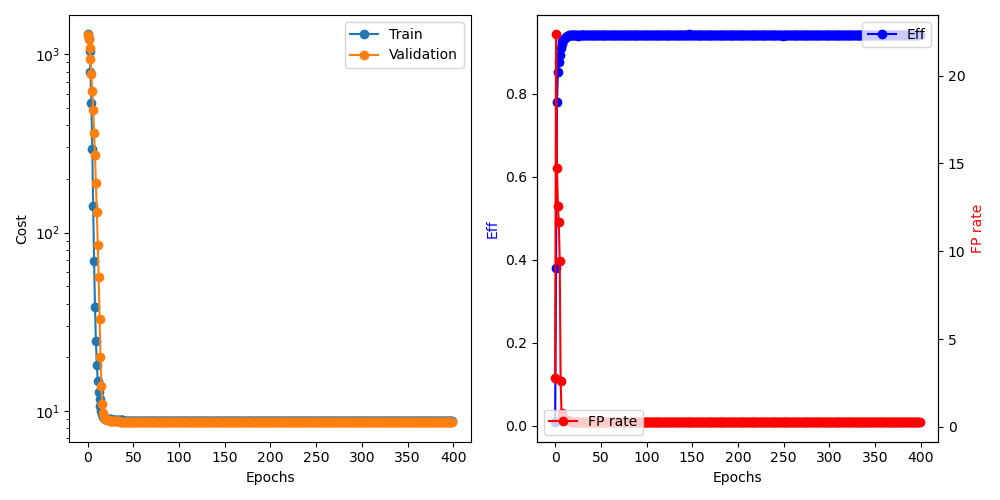

In [12]:
avgEff=0
avgFP=0
print('for model: ', model)   
run_name = 'ACN_3_P_10L_4S_BN (P5)'
# Create an mlflow run
with mlflow.start_run(run_name=run_name) as run:
    # Log parameters of the model
    for key, value in vars(args).items():
        print(key, value)
        mlflow.log_param(key, value)
    
    # Log parameter count in the model
    mlflow.log_param('Parameters', count_parameters(model))
    
    # Begin run
    for result in trainNet(model, optimizer, loss,
                            train_loader, val_loader,
                            args.epochs+args.epoch_start, epoch_start=args.epoch_start,
                            notebook=True, device=device):

        result = result._asdict()
        results = results.append(pd.Series(result), ignore_index=True)
    
        xs = results.index
    
        # Update the plot above
        lines['train'].set_data(results.index,results.cost)
        lines['val'].set_data(results.index,results.val)
    
        #filter first cost epoch (can be really large)
        max_cost = max(max(results.cost if len(results.cost)<2 else results.cost[1:]), max(results.val))
        min_cost = min(min(results.cost), min(results.val))
    
        # The plot limits need updating too
        ax.set_ylim(min_cost*.9, max_cost*1.1)  
        ax.set_xlim(-.5, len(results.cost) - .5)
    
        replace_in_ax(lax, lines['eff'], xs, results['eff_val'].apply(lambda x: x.eff_rate))
        replace_in_ax(tax, lines['fp'], xs, results['eff_val'].apply(lambda x: x.fp_rate))
    
        # Redraw the figure
        fig.canvas.draw()
            
        ## MLFLOW ##
        # Log metrics
        mlflow.log_metric('Efficiency', result['eff_val'].eff_rate, result['epoch'])
        mlflow.log_metric('False Positive Rate',  result['eff_val'].fp_rate, result['epoch'])
        mlflow.log_metric('Validation Loss',  result['val'], result['epoch'])
        mlflow.log_metric('Training Loss',  result['cost'], result['epoch'])
        
        print('Result epoch: ', result['epoch'])
        if(result['epoch'] >= args.epochs + args.epoch_start - 10):
            avgEff += result['eff_val'].eff_rate
            avgFP += result['eff_val'].fp_rate
           
        if(result['epoch'] == args.epochs + args.epoch_start - 1):
            print('Averaging...\n')
            avgEff /= 10
            avgFP /= 10
            mlflow.log_metric('10 Efficiency Average', avgEff)
            mlflow.log_metric('10 False Positive Average', avgFP)
            
        print('Average Eff: ', avgEff)
        print('Average FP Rate: ', avgFP)
            
        # Log tags
#        mlflow.set_tag('Optimizer', 'Adam')
#        mlflow.set_tag('Kernel size', 'Mixed')
#        mlflow.set_tag('Skip connections', '3')
#        mlflow.set_tag('Activation', 'Softplus')
#        mlflow.set_tag('Mid Activation', 'Relu')
        mlflow.set_tag('Asymmetry', '2.5')
        mlflow.set_tag('KDE', 'Poca')

        # Save model state dictionary, optimizer state dictionary, and epoch number
        torch.save({
            'model':model.state_dict(),
            'optimizer':optimizer.state_dict(),
            'epoch':args.epochs+result['epoch']
            }, 'run_stats.pyt')
        # Save the run stats into mlflow
        mlflow.log_artifact('run_stats.pyt')
            
        # Save a diagram of the architecture
#        HL.transforms.Fold("Conv", "Conv"),
#        HL.build_graph(model, torch.zeros([args.batch_size, 1, 4000]).to(device)).save('architecture', format='png')
#        mlflow.log_artifact('architecture.png')
        
        # log the code for the model architecture
#        mlflow.log_artifact('architecture.txt')
        
    dual_train_plots(results.index,
                 results.cost, results.val, 
                 results['eff_val'].apply(lambda x: x.eff_rate),
                 results['eff_val'].apply(lambda x: x.fp_rate))
    # save plot
    plt.tight_layout()
    plt.savefig('plot.png')
    mlflow.log_artifact('plot.png')

In [13]:
##quit()

/data/conda/envs/goofit-june2020/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
